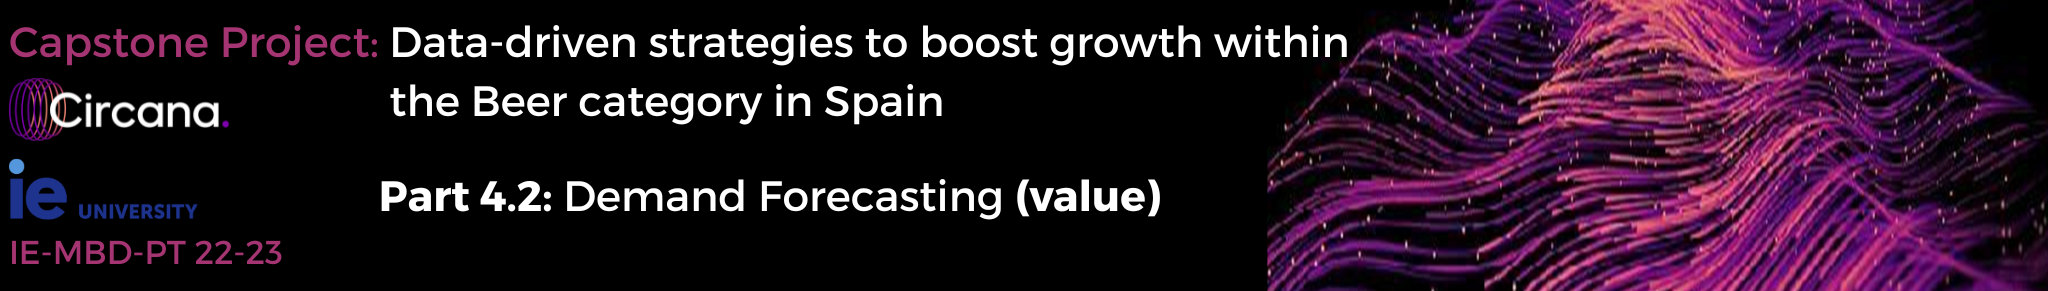

In [191]:
from IPython.display import Image
Image(filename='images/header-part4.2.png')

**As we have already mentioned in notebook part 4.1., we have divided the exercise of forecasting into 2 parts, that follow the overall same structure: first, with the volumen, then with the value. We have tried to create different models as value is having the impact of prices on it. Due to the current situation and high inflation existing, we have thought that performing the forecasting in a separate way (volume and value) makes more sense and can avoid potential biases.**

This notebook will cover the forecasting of demand value, following the same approach than for volume

## <span style="color: purple">**Table of contents**</span> <a class="anchor"></a>
- [<span style="color: purple">0. Preparing the environment</span>](#section_0)
- [<span style="color: purple">1. Exploratory Data Analysis for Demand Forecasting</span>](#section_1)
  - [<span style="color: purple">1.1. Preparing the data</span>](#section_1_1)
  - [<span style="color: purple">1.2. Analyzing our data evolution through time</span>](#section_1_2)
- [<span style="color: purple">2. Modeling for Segment Demand Forecasting</span>](#section_2)
  - [<span style="color: purple">2.1. Simple Autoarima model</span>](#section_2_1)
  - [<span style="color: purple">2.2. Autoarima model with hyperparameter tuning</span>](#section_2_2)
  - [<span style="color: purple">2.3. Simple LightGBM</span>](#section_2_3)
  - [<span style="color: purple">2.4. Complete Light GBM</span>](#section_2_4)
- [<span style="color: purple">3. Modeling for Manufacturer Demand Forecasting</span>](#section_3)
  - [<span style="color: purple">3.1. Simple Autoarima model</span>](#section_3_1)
  - [<span style="color: purple">3.2. Autoarima model with hyperparameter tuning</span>](#section_3_2)
  - [<span style="color: purple">3.3. Simple LightGBM</span>](#section_3_3)
  - [<span style="color: purple">3.4. Complete Light GBM</span>](#section_3_4)
- [<span style="color: purple">4. Modeling for Stores Demand Forecasting</span>](#section_4)
  - [<span style="color: purple">4.1. Light GBM</span>](#section_4_1)
  - [<span style="color: purple">4.2. Light GBM with Finetuning</span>](#section_4_2)
- [<span style="color: purple">5. Forecasting applying the best models</span>](#section_5)
  - [<span style="color: purple">5.1. Short Term Forecasting for segments</span>](#section_5_1)
  - [<span style="color: purple">5.2. Long Term Forecasting for segments</span>](#section_5_2)
  - [<span style="color: purple">5.3. Short Term Forecasting for manufacturers</span>](#section_5_3)
  - [<span style="color: purple">5.4. Long Term Forecasting for manufacturers</span>](#section_5_4)
  - [<span style="color: purple">6. Conclusions on the work performed</span>](#section_6)
- [<span style="color: purple">7. Some "big" numbers on the forecasting</span>](#section_7)
  - [<span style="color: purple">7.1. The 2023-2024 numbers for segments</span>](#section_7_1)
  - [<span style="color: purple">7.2. The 2023-2024 numbers for manufacturers</span>](#section_7_2)
  - [<span style="color: purple">7.3. The 2023-2024 numbers for beer</span>](#section_7_3)
- [<span style="color: purple">8. A final combined approach</span>](#section_8)

  

  


## <span style="color: purple">**0. Preparing the environment**</span> <a class="anchor" id="section_0"></a>

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer


#Autoarima
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Autoarima with hyperparameter tuning
from itertools import product

#LightGBM
import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer


import warnings
warnings.filterwarnings("ignore")

In [2]:
#We import the data, based on the previously created dataset
original_data = pd.read_csv('datasets/circana_data.csv')


# <span style="color: purple">**1. Preparing the data**</span> <a class="anchor" id="section_1"></a>


## <span style="color: purple">1.1. Preparing the data</span> <a class="anchor" id="section_1_1"></a>

As the objective that the client want us to achieve is to forecast segment demand and manufacturer demand, we will start by preparing and analyzing the data to accomplish that objective.

In [4]:
#Creating a new DataFrame with the columns for our analysis
ts_simple_data = original_data[['Week Code', 'Sales in value (€)', 'SEGMENT','MANUFACTURER','Month', 'Year', 'Season', 'Quarter']]

In [4]:
#We will sort the data by the Week Code
ts_simple_data = ts_simple_data.sort_values(by=['Week Code'])

In [5]:
#As we have many rows with the same combination, we will group the data by the columns we want to analyze
ts_simple_data= ts_simple_data.groupby(["Week Code", "SEGMENT", "MANUFACTURER", "Month", "Year", "Season", "Quarter"]).sum().reset_index()

In [6]:
ts_simple_data.head()

Week Code   SEGMENT         MANUFACTURER  Month  Year  Season  Quarter  \
0          1  ARTISANS       MANUFACTURER 5      1  2021  Winter        1   
1          1  ARTISANS  OTHER MANUFACTURERS      1  2021  Winter        1   
2          1     BLACK       MANUFACTURER 1      1  2021  Winter        1   
3          1     BLACK       MANUFACTURER 2      1  2021  Winter        1   
4          1     BLACK       MANUFACTURER 3      1  2021  Winter        1   

   Sales in value (€)  
0              766.69  
1             5296.45  
2             1359.37  
3             6159.95  
4             1659.79

In [7]:
ts_simple_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           6702 non-null   int64  
 1   SEGMENT             6702 non-null   object 
 2   MANUFACTURER        6702 non-null   object 
 3   Month               6702 non-null   int64  
 4   Year                6702 non-null   int64  
 5   Season              6702 non-null   object 
 6   Quarter             6702 non-null   int64  
 7   Sales in value (€)  6702 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 419.0+ KB


## <span style="color: purple">1.2. Analyzing our data evolution through time</span> <a class="anchor" id="section_1_2"></a>

Despite we have already performed a detailed EDA at the beginning of our project, at this stage we will start our time series analysis but plotting some visualizations closely related with the temporal evolution of sales.

First, we will plot how **sales of the category (beer)** have been evolving through the period.

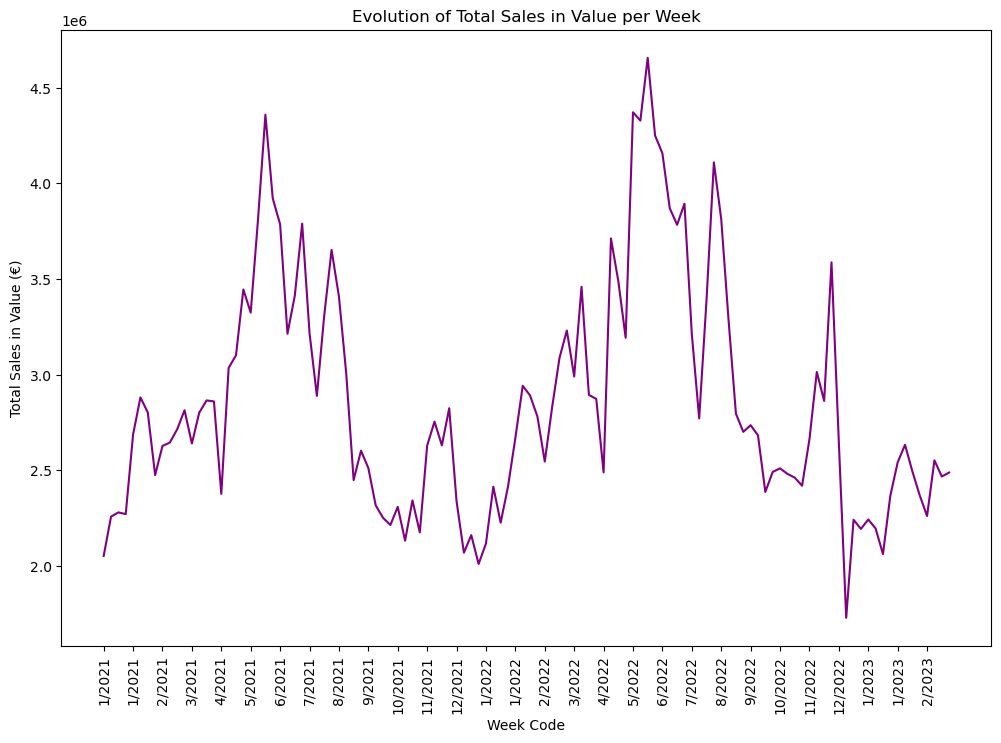

In [8]:
#Group df by week code
weekly_sales = ts_simple_data.groupby('Week Code')['Sales in value (€)'].sum()

#Get month and year for each week code
months = ts_simple_data.groupby('Week Code')['Month'].first()
years = ts_simple_data.groupby('Week Code')['Year'].first()

#Plotting the graph
plt.figure(figsize=(12, 8))
plt.plot(weekly_sales.index, weekly_sales.values, color= 'purple')
plt.xlabel('Week Code')
plt.ylabel('Total Sales in Value (€)')
plt.title('Evolution of Total Sales in Value per Week')

labels = [f"{months[week]}/{years[week]}" for week in weekly_sales.index]
display_labels = labels[::4]
display_indices = weekly_sales.index[::4]
plt.xticks(display_indices, display_labels, rotation='vertical')

plt.show()


As we can see the beer sales seem (in general terms) quite stable (not increasing or decreasing market) but with a high seasonality factor, with high peaks and drops

Now, let's analyze the weekly sales evolution but, this time, depending on **segment**

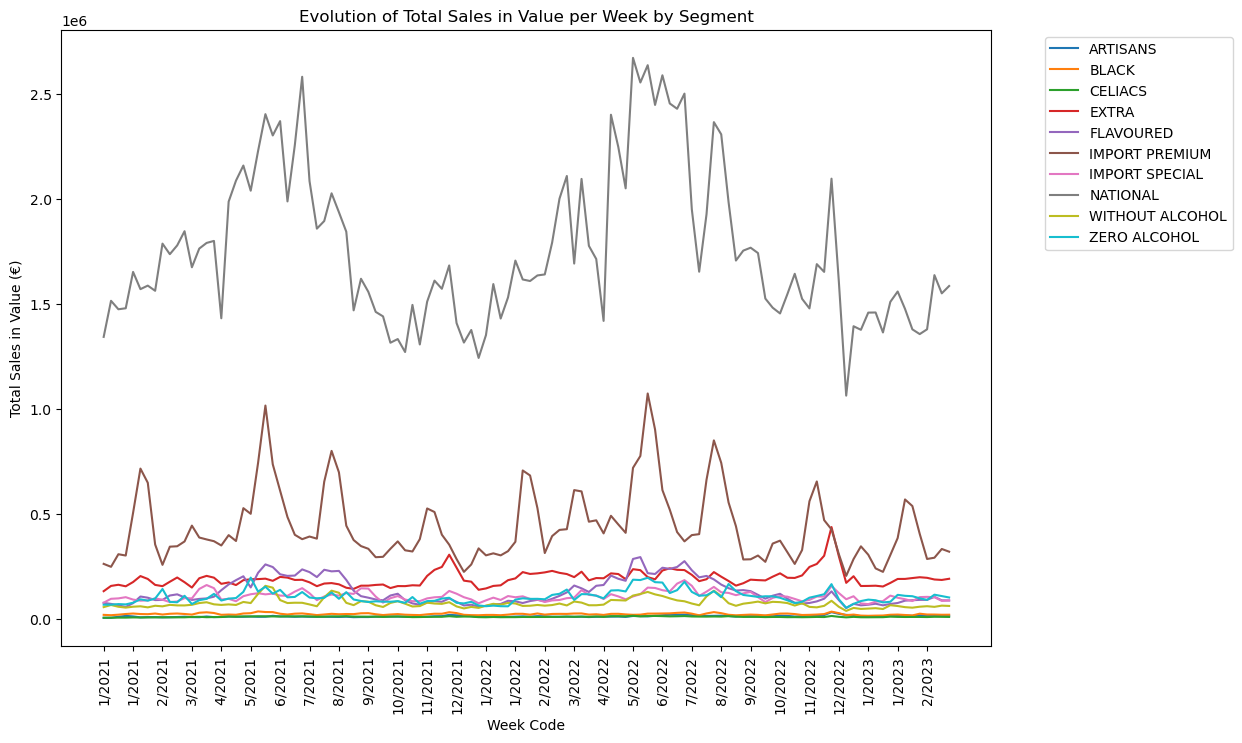

In [9]:

#Group df by week code and segment
segment_sales = ts_simple_data.groupby(['Week Code', 'SEGMENT'])['Sales in value (€)'].sum()

#Get the unique segments
segments = ts_simple_data['SEGMENT'].unique()


plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each segment
for segment in segments:
    segment_data = segment_sales.loc[:, segment]
    plt.plot(segment_data.index, segment_data.values, label=segment)

plt.xlabel('Week Code')
plt.ylabel('Total Sales in Value (€)')
plt.title('Evolution of Total Sales in Value per Week by Segment')

#We add the months labels previously created
labels = [f"{months[week]}/{years[week]}" for week in weekly_sales.index]
display_labels = labels[::4]
display_indices = weekly_sales.index[::4]
plt.xticks(display_indices, display_labels, rotation='vertical')


#Adjust the legend position to be able to see the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Quite interesting graph. As we can see, the seasonality factor is present in all of the segments but **national** segment is much more stable than **import premium** (the second most popular segment) which has much more fluctuations in shorter periods.

The other segments have significantly lower sales, so we will **normalize the data** to be able to compare all the segments easier.

Comparing the results with the volume analysis, we can infer that ***Import Premium** segment, has biggest increases in sales in volume than in sales in value, so obviosuly, at this point, we should conclude that prices are also fluctuating on that segment. Also, **Extra** segment is more relevant in terms of value than in terms of volume, so we can conclude that prices are higher in that segment.

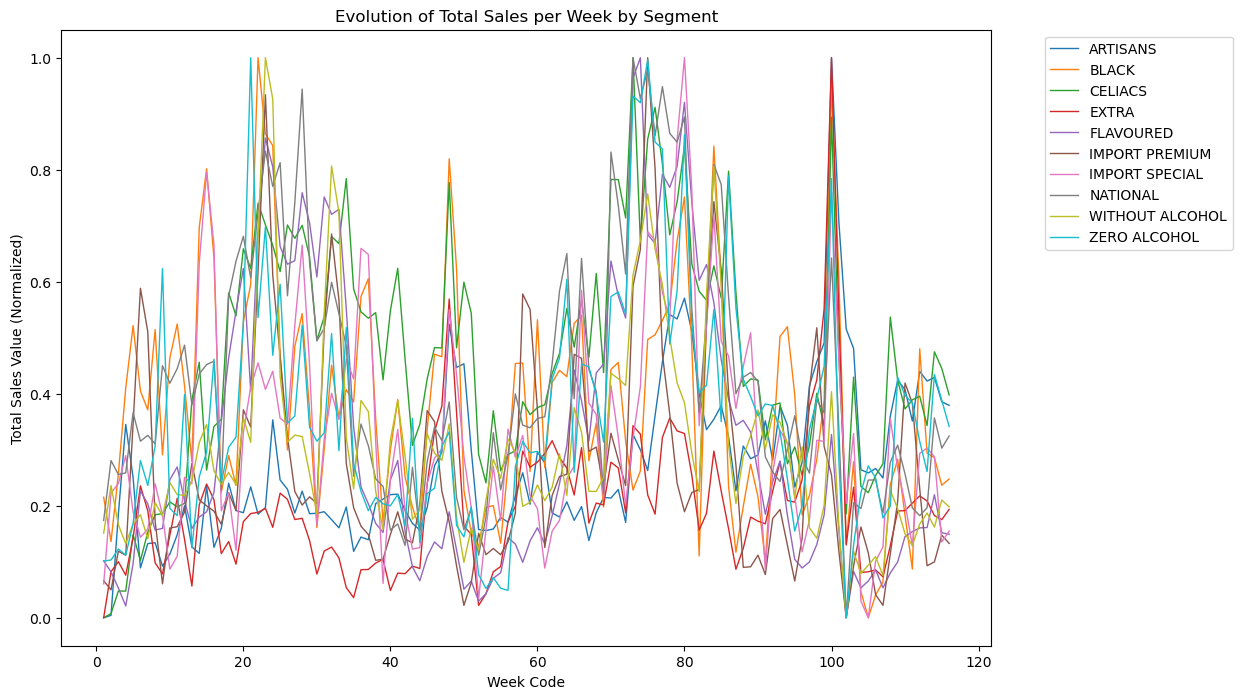

In [10]:

#We start by normalizing the sales volume between 0 and 1 for each segment
normalized_sales = segment_sales.groupby('SEGMENT').apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each segment
for segment in segments:
    segment_data = normalized_sales.loc[:, segment]
    plt.plot(segment_data.index, segment_data.values, label=segment, linewidth=1)

plt.xlabel('Week Code')
plt.ylabel('Total Sales Value (Normalized)')
plt.title('Evolution of Total Sales per Week by Segment')


#Adjust the legend position for a better visualization
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

It seems as if not all the segments have the same periods of fluctuations. But, as we cannot visualize that aspect properly, let's print each of them separately

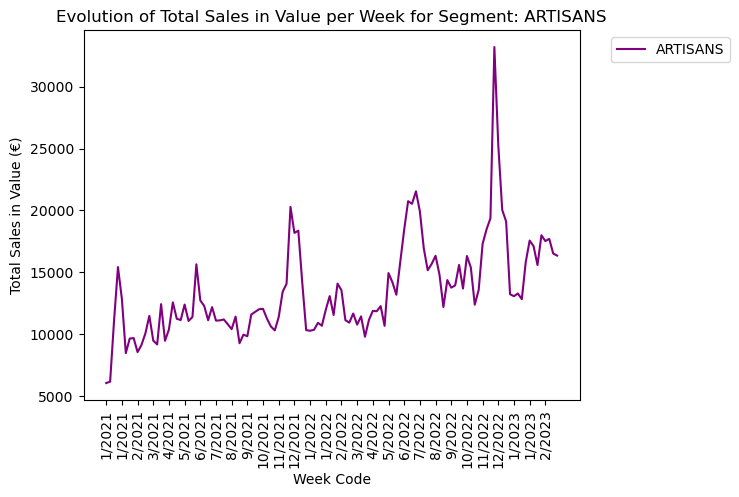

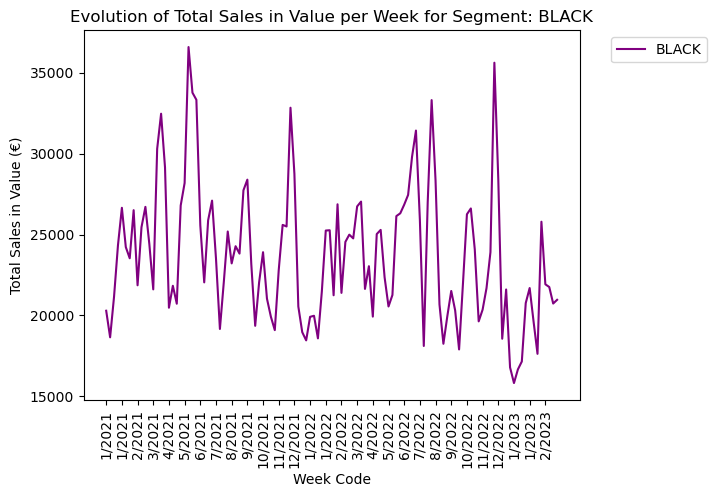

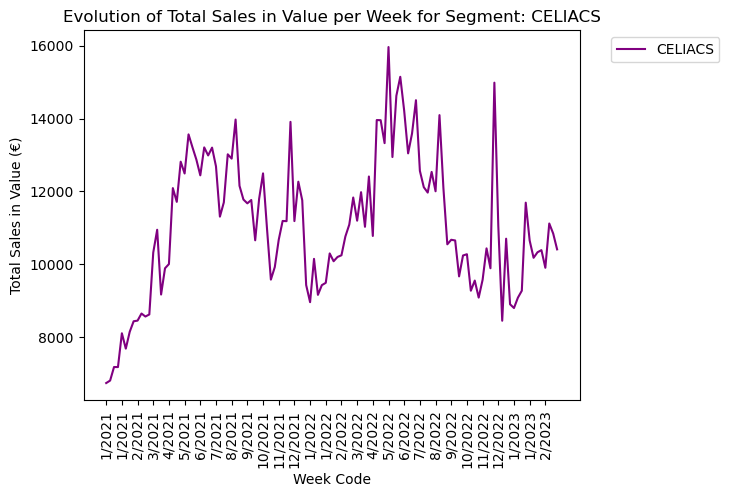

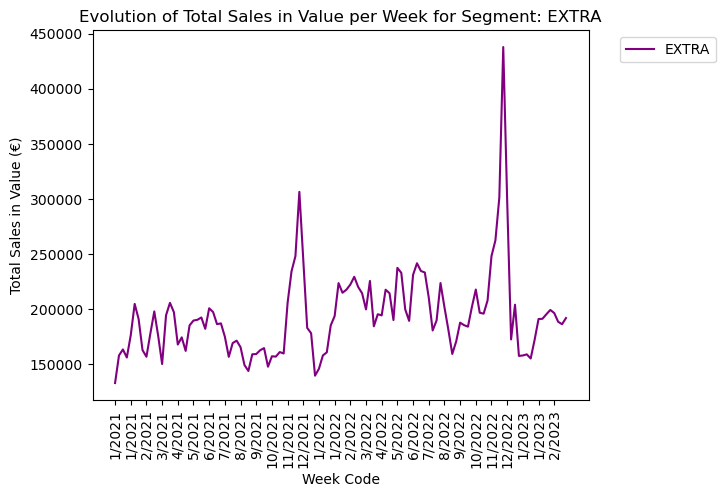

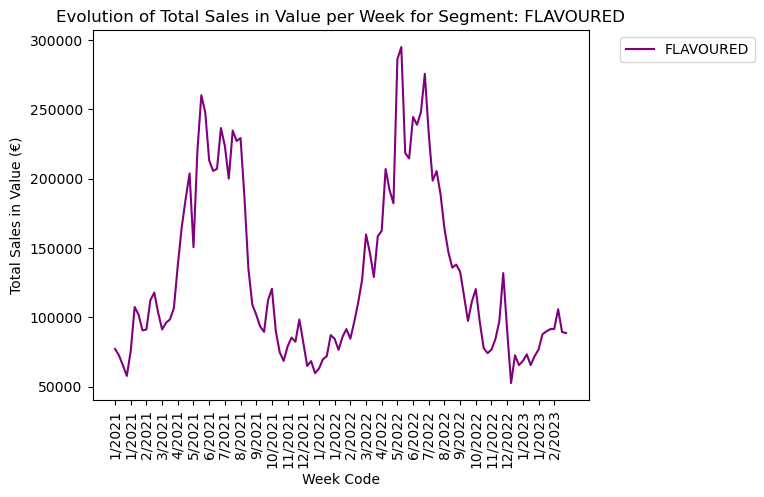

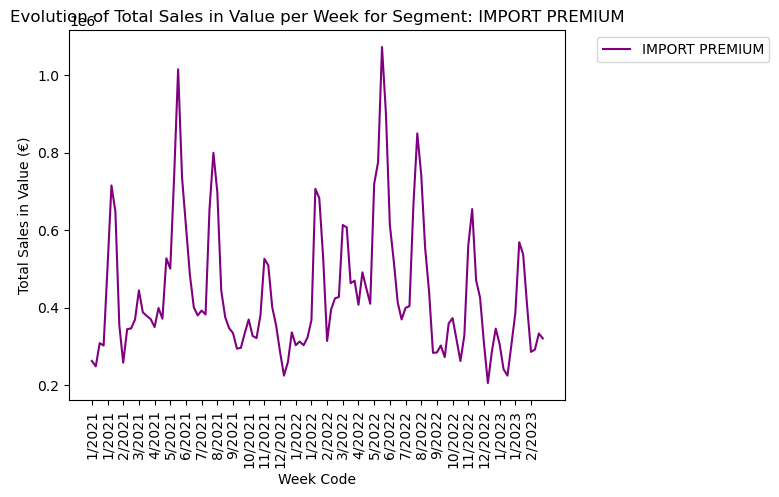

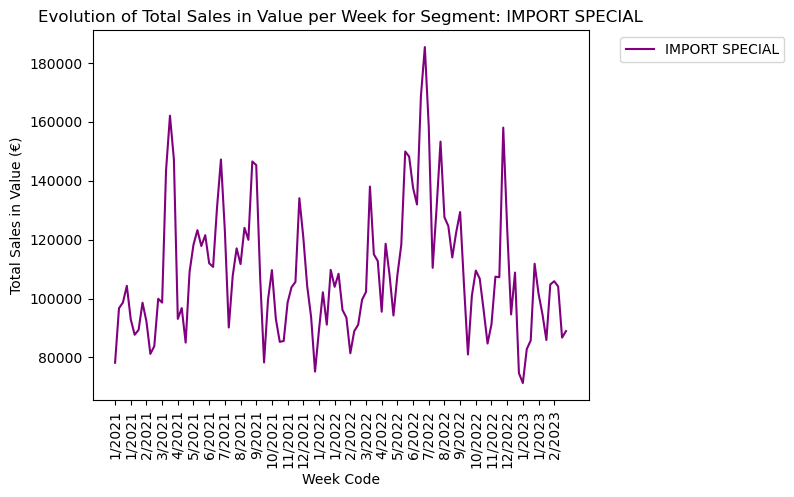

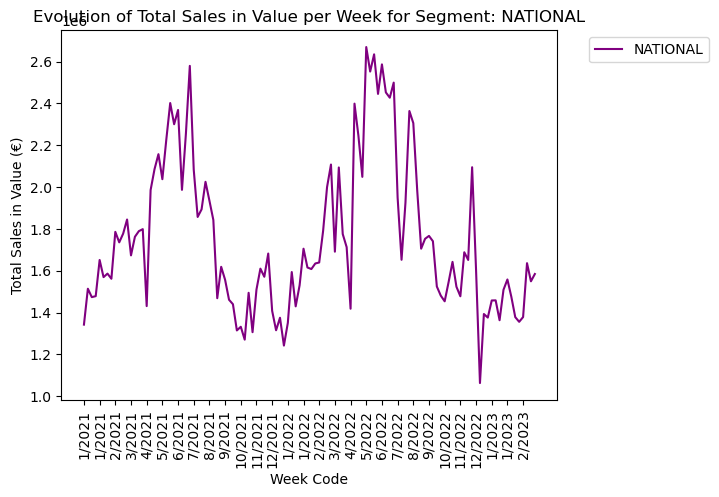

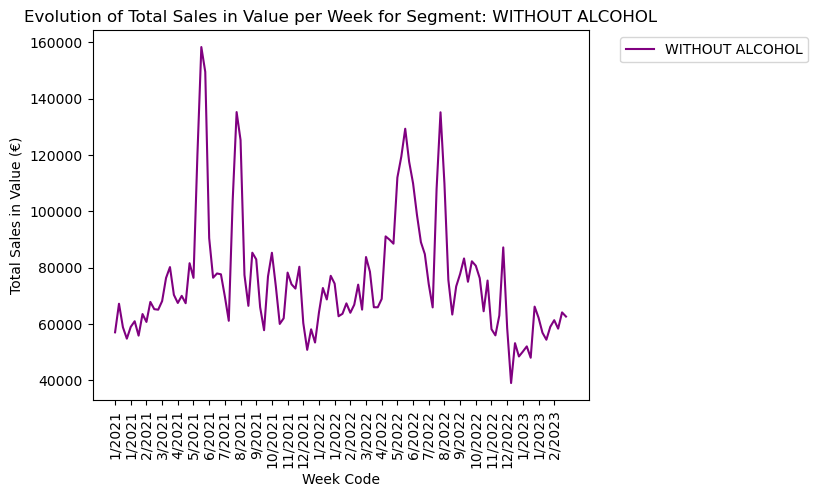

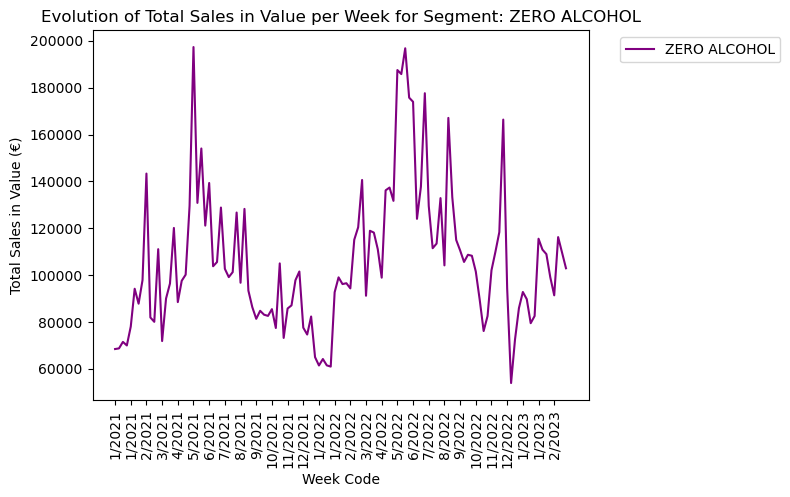

In [11]:
#Iterate over each segment and create a separate plot
for segment in segments:
    #First, we create a new figure and axes for each segment
    fig, ax = plt.subplots()
    
    #We get the specific data of the segment
    segment_data = segment_sales.loc[:, segment]
    
    #Plot the data
    ax.plot(segment_data.index, segment_data.values, label=segment, color='purple')
    ax.set_xlabel('Week Code')
    ax.set_ylabel('Total Sales in Value (€)')
    ax.set_title(f'Evolution of Total Sales in Value per Week for Segment: {segment}')
    

    #Display previosuly created labels
    display_labels = labels[::4]
    display_indices = segment_data.index[::4]
    ax.set_xticks(display_indices)
    ax.set_xticklabels(display_labels, rotation='vertical')
    
    #Adjust the legend position for better visualization
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

From the previous graphs, we should infere that **all of the segments but one, present a mirror-like behavior in comparison with the volume analysis** performed in notebook part 4.1, so we remmit to that notebook to see the analysis of the segments.

It is worthy mention that the increases in **Import Special** segment are much higher than in Volume, so we can infer that the price of the products in this segment has been increasing through last periods.

Now, let's analyze the weekly sales evolution but, this time, depending on **manufacturer**

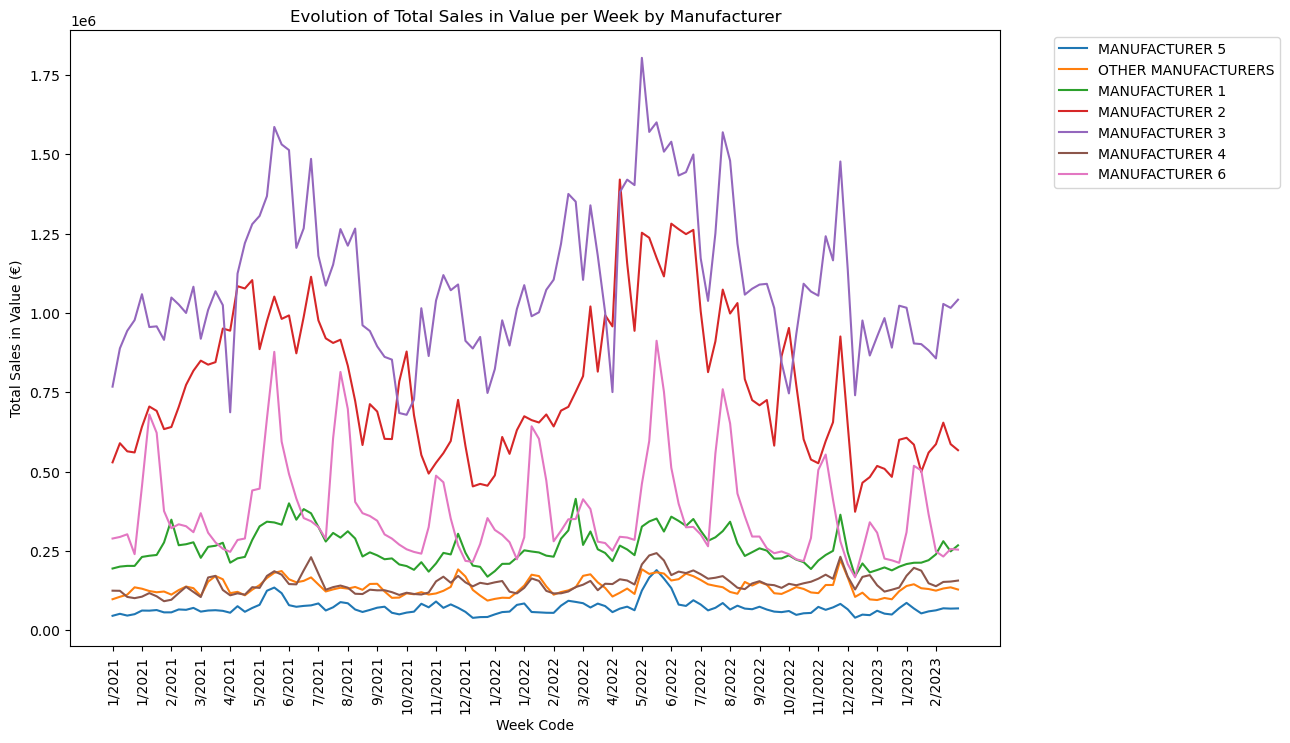

In [12]:

#Group df by week code and manufacturer
manufacturer_sales = ts_simple_data.groupby(['Week Code', 'MANUFACTURER'])['Sales in value (€)'].sum()

#Get the unique manufacturer
manufacturers = ts_simple_data['MANUFACTURER'].unique()


plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each manufacturer
for manufacturer in manufacturers:
    manufacturer_data = manufacturer_sales.loc[:, manufacturer]
    plt.plot(manufacturer_data.index, manufacturer_data.values, label=manufacturer)

plt.xlabel('Week Code')
plt.ylabel('Total Sales in Value (€)')
plt.title('Evolution of Total Sales in Value per Week by Manufacturer')

#We add the months labels previously created
labels = [f"{months[week]}/{years[week]}" for week in weekly_sales.index]
display_labels = labels[::4]
display_indices = weekly_sales.index[::4]
plt.xticks(display_indices, display_labels, rotation='vertical')


#Adjust the legend position to be able to see the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

As some comments to add, in comparison with sales in volume: **manufacturer 6** is a manufacturer that sells a lot of volume but not so much value. It frequently performs better than manufacturer 2, and sometimes than manufacturer 3, in volume, but this is not the case in value.

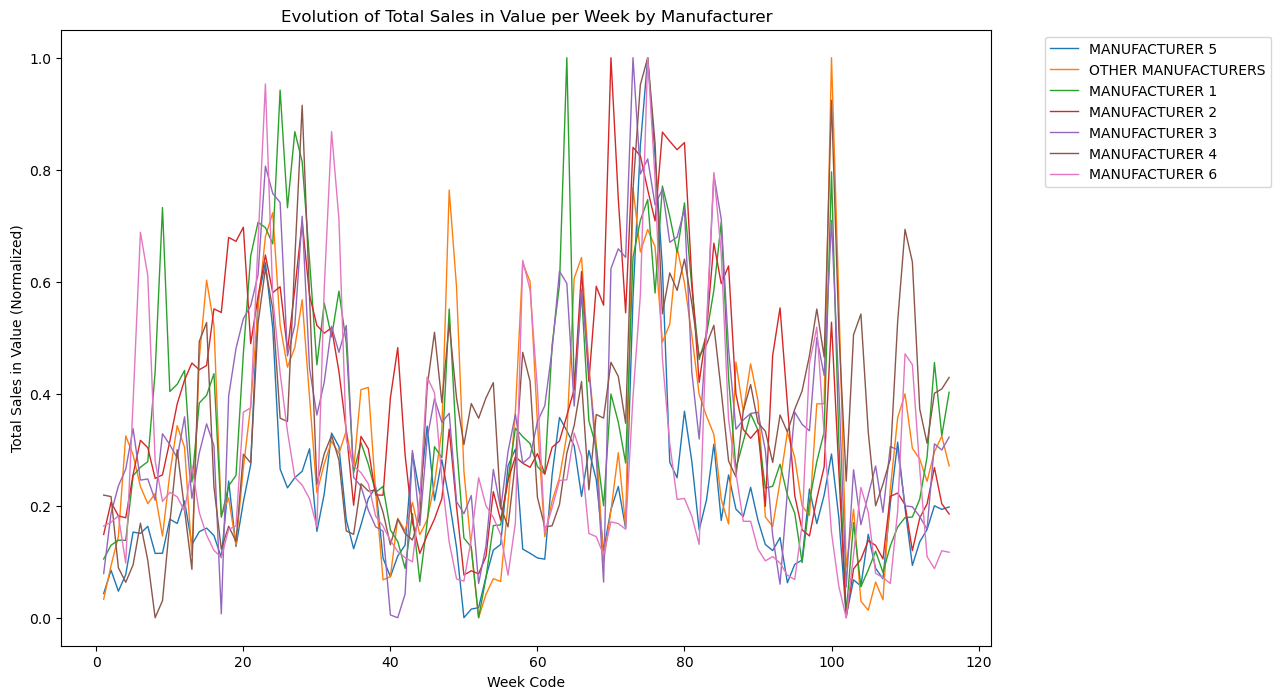

In [13]:

#We start by normalizing the sales volume between 0 and 1 for each manufacturer
normalized_manufacturer = manufacturer_sales.groupby('MANUFACTURER').apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(12, 8))

#Plotting the graph with a line for each manufacturer
for manufacturer in manufacturers:
    manufacturer_data = normalized_manufacturer.loc[:, manufacturer]
    plt.plot(manufacturer_data.index, manufacturer_data.values, label=manufacturer, linewidth=1)

plt.xlabel('Week Code')
plt.ylabel('Total Sales in Value (Normalized)')
plt.title('Evolution of Total Sales in Value per Week by Manufacturer')


#Adjust the legend position for a better visualization
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

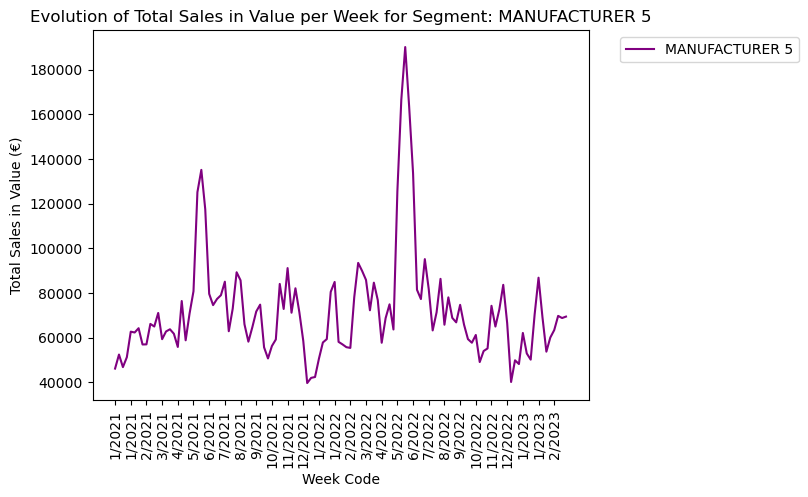

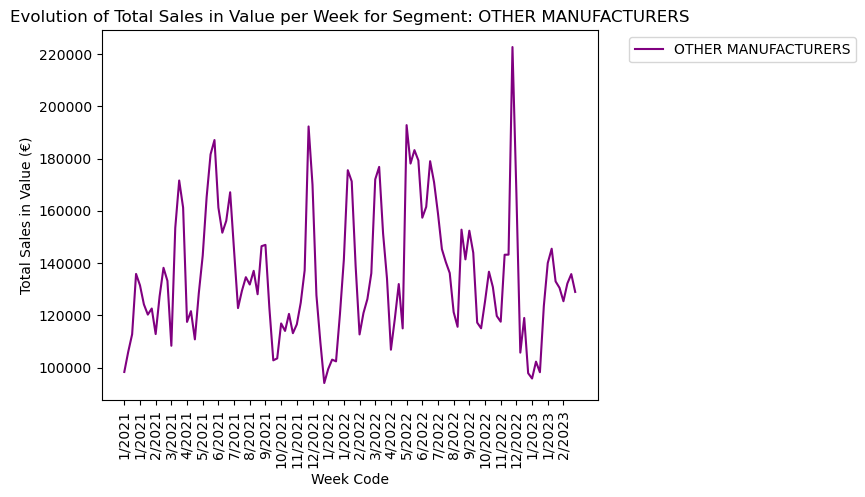

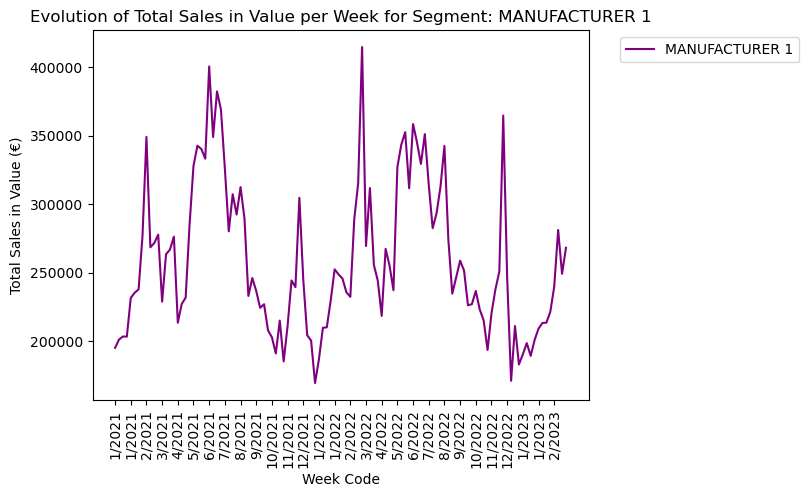

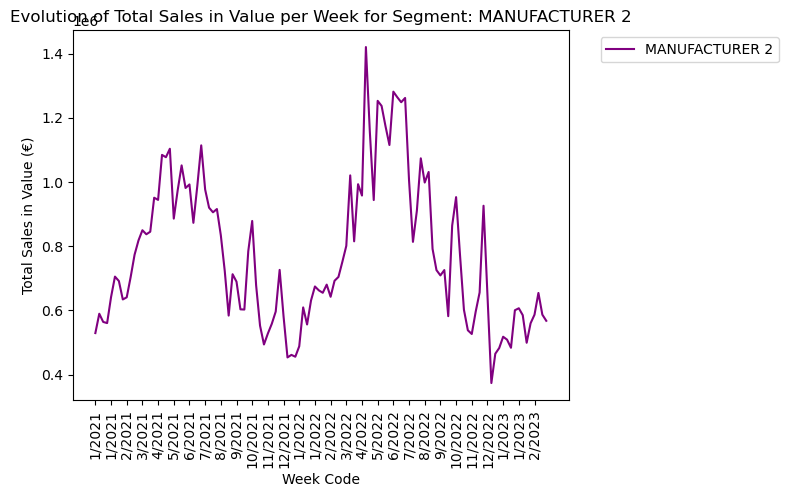

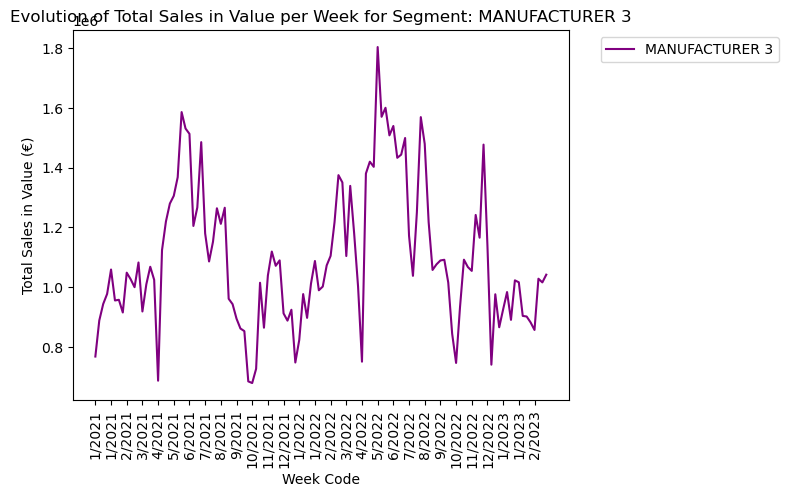

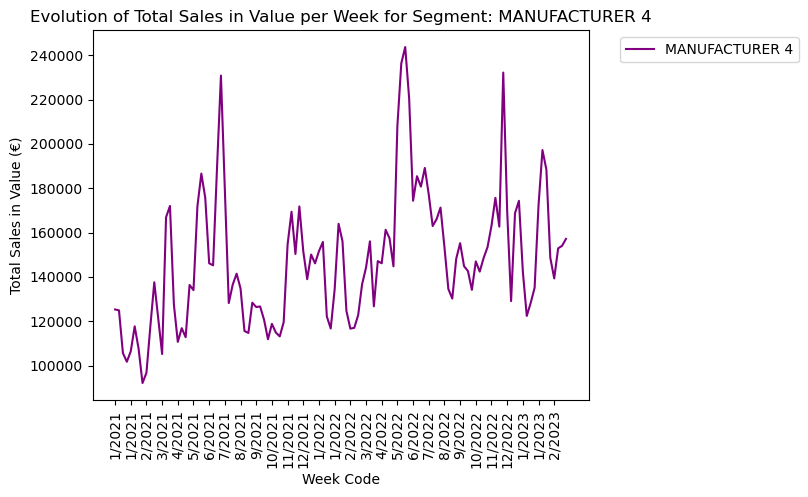

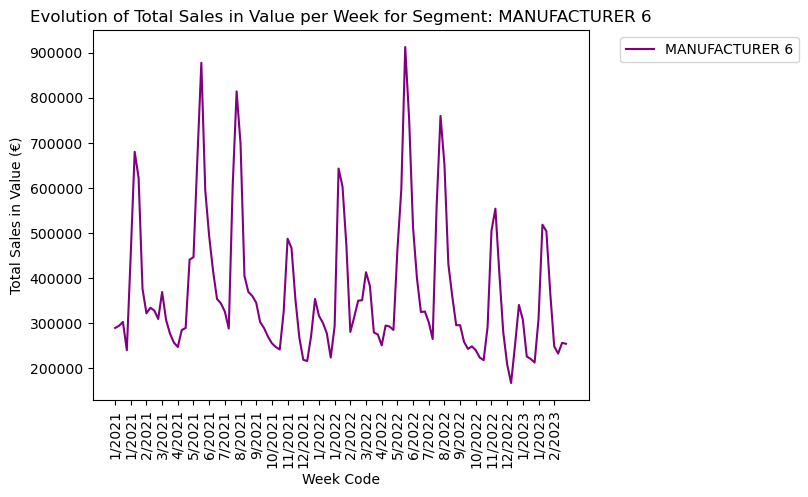

In [14]:
#Iterate over each segment and create a separate plot
for manufacturer in manufacturers:
    #First, we create a new figure and axes for each segment
    fig, ax = plt.subplots()
    
    #We get the specific data of the segment
    manufacturer_data = manufacturer_sales.loc[:, manufacturer]
    
    #Plot the data
    ax.plot(manufacturer_data.index, manufacturer_data.values, label=manufacturer, color='purple')
    ax.set_xlabel('Week Code')
    ax.set_ylabel('Total Sales in Value (€)')
    ax.set_title(f'Evolution of Total Sales in Value per Week for Segment: {manufacturer}')
    

    #Display previosuly created labels
    display_labels = labels[::4]
    display_indices = manufacturer_data.index[::4]
    ax.set_xticks(display_indices)
    ax.set_xticklabels(display_labels, rotation='vertical')
    
    #Adjust the legend position for better visualization
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

In general, there are not really drastic differences in between the sales in volume and sales in value of the manufacturers. Though, it is worth mentioning that **Other manufacturers** are having a lower recovery in the Q1 of 2023 in value than in volume, so we can infer that the price of the products in this segment has been decreasing through last periods.

# <span style="color: purple">**2. Modeling for Segment Demand Forecasting**</span> <a class="anchor" id="section_2"></a>

## <span style="color: purple">2.1. Simple Autoarima model</span> <a class="anchor" id="section_2_1"></a>

First, we will divide our data into train and test sets. Then we will fit a simple autoarima model to our data and plot the results.

In [15]:
#We get a copy of the df
ts_simple_autoarima = ts_simple_data.copy()

In [16]:
#We do the preparations for having a dataset suitable to be used by the autoarima function
ts_simple_autoarima = ts_simple_autoarima.set_index('Week Code')
ts_simple_autoarima = ts_simple_autoarima.drop(['Month', 'Year', 'Season', 'Quarter'], axis=1)

ts_simple_autoarima_segment = ts_simple_autoarima.drop(['MANUFACTURER'], axis=1)
ts_simple_autoarima_segment = ts_simple_autoarima_segment.groupby(['Week Code', 'SEGMENT'])['Sales in value (€)'].sum().reset_index()

In [17]:
ts_simple_autoarima_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           1160 non-null   int64  
 1   SEGMENT             1160 non-null   object 
 2   Sales in value (€)  1160 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 27.3+ KB


In [18]:
ts_simple_autoarima_segment = ts_simple_autoarima_segment.set_index('Week Code')

In [19]:
#On this snippet of code, we will train the AutoARIMA model for each segment and store the model in a dictionary. We will comment each step to facilitate its understanding and replication.

#We create a dictionary to store the models and the data for each segment
segment_models = {}
segment_data_dict = {}

#We get the unique segments
unique_segments = ts_simple_autoarima_segment['SEGMENT'].unique()

for segment in unique_segments:
    #Extract the data for the segment we are working on
    segment_data = ts_simple_autoarima_segment[ts_simple_autoarima_segment['SEGMENT'] == segment]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(segment_data['Sales in value (€)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    segment_data_dict[segment] = {'train': train_data, 'val': val_data}

    #Fit the AutoARIMA model to the train set and store it in the dictionary
    model = auto_arima(train_data)
    segment_models[segment] = model


In [20]:
#We take a look at the models created for each segment
for segment, model in segment_models.items():
    print(f"Segment: {segment}")
    print(model.summary())
    print("-------------------")

Segment: ARTISANS
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1008.804
Date:                Sun, 02 Jul 2023   AIC                           2019.608
Time:                        19:29:55   BIC                           2022.299
Sample:                             0   HQIC                          2020.700
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.345e+06   3.88e+05     16.370      0.000    5.58e+06     7.1e+06
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):               278.77
Prob(Q):                     

In [21]:
#Let's check that our validation data has been stored correctly
for segment, data in segment_data_dict.items():
    print(f"Segment: {segment}")
    print(data['val'])
    print("-------------------")

Segment: ARTISANS
Week Code
111    15591.32
112    18000.61
113    17529.23
114    17706.02
115    16523.67
116    16353.07
Name: Sales in value (€), dtype: float64
-------------------
Segment: BLACK
Week Code
111    17630.08
112    25793.21
113    21927.50
114    21757.95
115    20738.04
116    20967.64
Name: Sales in value (€), dtype: float64
-------------------
Segment: CELIACS
Week Code
111    10328.38
112    10387.46
113     9903.02
114    11119.28
115    10843.61
116    10408.58
Name: Sales in value (€), dtype: float64
-------------------
Segment: EXTRA
Week Code
111    195365.00
112    199259.60
113    196498.61
114    188552.06
115    186322.86
116    191906.10
Name: Sales in value (€), dtype: float64
-------------------
Segment: FLAVOURED
Week Code
111     89884.81
112     91513.43
113     91655.70
114    105853.56
115     89372.98
116     88770.50
Name: Sales in value (€), dtype: float64
-------------------
Segment: IMPORT PREMIUM
Week Code
111    537865.21
112    405462.29
1

In [22]:
#So, after training our model in our train set, we can use it to make predictions on the validation set. We will store the predictions in a new DataFrame and add it to the dictionary. Also here, the code will be commented in detail to facilitate its understanding and replication.

#We will apply the model to the validation set of each segment
for segment, model in segment_models.items():
    #Extract the validation data for the segment
    val_data = segment_data_dict[segment]['val']

    #Apply the model to the validation data and store the predictions
    predictions = model.predict(n_periods=len(val_data)+1)

    #Create a new DataFrame to store the predictions with the correct index ad then, store it in the dictionary
    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])
    segment_data_dict[segment]['predictions'] = predictions_df

#Print the predictions for each segment
for segment, data in segment_data_dict.items():
    print(f"Segment: {segment}")
    print(data['predictions'])
    print("-------------------")

Segment: ARTISANS
           Predictions
Week Code             
111           17115.63
112           17115.63
113           17115.63
114           17115.63
115           17115.63
116           17115.63
-------------------
Segment: BLACK
            Predictions
Week Code              
111        23041.059441
112        23791.668275
113        23791.668275
114        23791.668275
115        23791.668275
116        23791.668275
-------------------
Segment: CELIACS
            Predictions
Week Code              
111        10456.428672
112        10539.064964
113        10589.903059
114        10555.247146
115        10601.154451
116        10603.332202
-------------------
Segment: EXTRA
             Predictions
Week Code               
111        197491.038247
112        198231.724887
113        200667.992798
114        201202.736869
115        202248.833233
116        202566.960402
-------------------
Segment: FLAVOURED
             Predictions
Week Code               
111         91735.

In [23]:
#After applying our trained autoarima models for each segment to each validation set, we should check how are they performing. For that, we will calculate the MSE and MAPE for each segment model. We will also comment each step to facilitate its understanding and replication.

#We create the function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#We initialize 2 list which will store the errors for each of the segment' models
mse_list = []
mape_list = []

#We make an iteration over each segment
for segment in segment_data_dict.keys():

    #First we get the true values of the validation set, which we stored in the dictionary
    y_true = segment_data_dict[segment]['val']
    
    #Then, we get the predictions of the validation set after applying the model
    y_pred = segment_data_dict[segment]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list.append(mape)

    #Print the results for each segment
    print(f"Segment: {segment}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

Segment: ARTISANS
MSE: 759708.3806333337
MAPE: 4.772088998899329%
-------------------
Segment: BLACK
MSE: 9699297.082688807
MAPE: 14.082249858002518%
-------------------
Segment: CELIACS
MSE: 154339.1731473358
MAPE: 3.135823653635359%
-------------------
Segment: EXTRA
MSE: 91715085.32983059
MAPE: 4.089678118361326%
-------------------
Segment: FLAVOURED
MSE: 52958394.302185334
MAPE: 6.7006942938978185%
-------------------
Segment: IMPORT PREMIUM
MSE: 12981830769.193419
MAPE: 32.71521046136296%
-------------------
Segment: IMPORT SPECIAL
MSE: 183588963.50072995
MAPE: 11.560583277138036%
-------------------
Segment: NATIONAL
MSE: 32515371130.973816
MAPE: 11.186423723737354%
-------------------
Segment: WITHOUT ALCOHOL
MSE: 107539221.21384872
MAPE: 17.205745674906133%
-------------------
Segment: ZERO ALCOHOL
MSE: 76515522.10000692
MAPE: 6.899814761466887%
-------------------


Some insights of this model:

**ARTISANS**:
MAPE: **4.77%**
This segment has a relatively low MAPE, indicating that the AutoARIMA model performs reasonably well in predicting sales.

**BLACK**:
MAPE: **14.08**
The BLACK segment has a significantly higher MAPE compared to the ARTISANS segment. It is almost 15% so model has to be improved.

**CELIACS**:
MAPE: **3.13%**
The CELIACS segment has a similar MAPE to the ARTISANS segment, indicating that the model performs relatively well in predicting sales for this segment.

**EXTRA**:
MAPE: **4.09%**
This segment has a relatively low MAPE, indicating that the AutoARIMA model performs reasonably well in predicting sales.

**FLAVOURED**:
MAPE: **6.7%**
The percentage error is relatively low, suggesting that the model performs reasonably well in predicting sales for this segment.

**ZERO ALCOHOL**:
MAPE: **6.89%**
The percentage error is relatively low, suggesting that the model performs reasonably well in predicting sales for this segment.

**NATIONAL**:
MAPE: **11.18%**
The sales in this segment are much higher than the previous segments,and our model is predicting relatively well. It can be improved but it is not bad.

**IMPORT SPECIAL**:
MAPE: **11.56%**
Here, the model also performs reasonably well, but it can be improved.

**WITHOUT ALCOHOL**:
MAPE: **17.20%**
The percentage error is relatively high, suggesting that the model performs poorly in predicting sales for this segment.

**IMPORT PREMIUM**:
MAPE: **32.71%**
The percentage error is really high, suggesting that the model performs poorly in predicting sales for this segment.

**At this point, it is worthy to mention that our ARIMA models are getting better results than the ones obtained in the notebook part 4.1**

## <span style="color: purple">2.2. Autoarima model with hyperparameter tuning</span> <a class="anchor" id="section_2_2"></a>


As we have seen, the simple Autoarima model can be used to predict sales for some segments, but it does not perform well for other segments. So, we will try to improve the performance of the model by tuning the hyperparameters.

In [24]:
#The code that we will present here will be simmilar than the one we used for the simple AutoARIMA model. The main difference is that we will use a grid search to find the best hyperparameters for each segment. We will comment each step to facilitate its understanding and replication.

#We create 2 new dictionaries, just to avoid potential overlappings with the previous ones
segment_models_2 = {}
segment_data_dict_2 = {}

#We get the unique segments
unique_segments = ts_simple_autoarima_segment['SEGMENT'].unique()

for segment in unique_segments:
    #Extract the data for the segment we are working on
    segment_data = ts_simple_autoarima_segment[ts_simple_autoarima_segment['SEGMENT'] == segment]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(segment_data['Sales in value (€)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    segment_data_dict_2[segment] = {'train': train_data, 'val': val_data}

    #Now, and this is the new part, we will prepare a list of hyperparameters to test
    p_values = [0, 1, 2, 3, 4]  #Different values for the AR order (p)
    d_values = [0, 1, 2] #Different values for the I order (d)
    q_values = [0, 1, 2, 3, 4] #Different values for the MA order (q)
    param_combinations = list(product(p_values, d_values, q_values))

    #We initialize the best model as None and best RMSE to infinity
    best_model = None
    best_rmse = np.inf

    #We perform grid search over the hyperparameter combinations
    for params in param_combinations:
        p, d, q = params

        #Fit the AutoARIMA model to the train set using the current hyperparameters
        model = auto_arima(train_data, start_p=p, d=d, start_q=q)

        #Make the predictions on the validation set
        forecast = model.predict(len(val_data))

        #Calculate root mean squared error (RMSE) for the validation set
        rmse = np.sqrt(mean_squared_error(val_data, forecast))

        #Update the best model if the current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model

    #Store the best model for each segment in the dictionary
    segment_models_2[segment] = best_model

In [25]:
#We take a look at the best models found for each segment
for segment, best_model in segment_models_2.items():
    print(f"Segment: {segment}")
    print(best_model.summary())
    print("-------------------")

Segment: ARTISANS
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1008.804
Date:                Sun, 02 Jul 2023   AIC                           2019.608
Time:                        19:45:27   BIC                           2022.299
Sample:                             0   HQIC                          2020.700
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.345e+06   3.88e+05     16.370      0.000    5.58e+06     7.1e+06
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):               278.77
Prob(Q):                     

In [26]:
#We will apply the model to the validation set of each segment so, as we have done in the autoarima model, we take a look at the validation set for each segment
for segment, data in segment_data_dict_2.items():
    print(f"Segment: {segment}")
    print(data['val'])
    print("-------------------")

Segment: ARTISANS
Week Code
111    15591.32
112    18000.61
113    17529.23
114    17706.02
115    16523.67
116    16353.07
Name: Sales in value (€), dtype: float64
-------------------
Segment: BLACK
Week Code
111    17630.08
112    25793.21
113    21927.50
114    21757.95
115    20738.04
116    20967.64
Name: Sales in value (€), dtype: float64
-------------------
Segment: CELIACS
Week Code
111    10328.38
112    10387.46
113     9903.02
114    11119.28
115    10843.61
116    10408.58
Name: Sales in value (€), dtype: float64
-------------------
Segment: EXTRA
Week Code
111    195365.00
112    199259.60
113    196498.61
114    188552.06
115    186322.86
116    191906.10
Name: Sales in value (€), dtype: float64
-------------------
Segment: FLAVOURED
Week Code
111     89884.81
112     91513.43
113     91655.70
114    105853.56
115     89372.98
116     88770.50
Name: Sales in value (€), dtype: float64
-------------------
Segment: IMPORT PREMIUM
Week Code
111    537865.21
112    405462.29
1

In [27]:
#This is exactly the same code as we used for the simple AutoARIMA model, but applying the best model found. We will apply the best model to the validation set of each segment and store the predictions in the dictionary.

for segment, best_model in segment_models_2.items():
    
    val_data = segment_data_dict_2[segment]['val']

    predictions = best_model.predict(n_periods=len(val_data)+1)

    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])

    segment_data_dict_2[segment]['predictions'] = predictions_df

#Print predictions of each segment
for segment, data in segment_data_dict_2.items():
    print(f"Segment: {segment}")
    print(data['predictions'])
    print("-------------------")

Segment: ARTISANS
           Predictions
Week Code             
111           17115.63
112           17115.63
113           17115.63
114           17115.63
115           17115.63
116           17115.63
-------------------
Segment: BLACK
            Predictions
Week Code              
111        21388.078374
112        22220.925349
113        22011.162962
114        22767.968539
115        22340.825960
116        22911.235562
-------------------
Segment: CELIACS
            Predictions
Week Code              
111        10456.428672
112        10539.064964
113        10589.903059
114        10555.247146
115        10601.154451
116        10603.332202
-------------------
Segment: EXTRA
             Predictions
Week Code               
111        193670.879709
112        192236.753488
113        192278.242035
114        192301.676188
115        192314.912600
116        192322.388978
-------------------
Segment: FLAVOURED
            Predictions
Week Code              
111        88701.305

In [28]:
#We will initialize lists to store MSE and MAPE for each segment
mse_list_2 = []
mape_list_2 = []

#Iterate over each segment
for segment in segment_data_dict_2.keys():

    # Get the true values from the validation set
    y_true = segment_data_dict_2[segment]['val']
    
    # Get the predicted values from the predictions DataFrame
    y_pred = segment_data_dict_2[segment]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_2.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_2.append(mape)

    #Print the results for each segment
    print(f"Segment: {segment}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
++    print("-------------------")

Segment: ARTISANS
MSE: 759708.3806333337
MAPE: 4.772088998899329%
-------------------
Segment: BLACK
MSE: 5709565.482528634
MAPE: 9.531229617934073%
-------------------
Segment: CELIACS
MSE: 154339.1731473358
MAPE: 3.135823653635359%
-------------------
Segment: EXTRA
MSE: 20023255.811228618
MAPE: 1.9934873715671315%
-------------------
Segment: FLAVOURED
MSE: 37930822.01616916
MAPE: 4.316609692356601%
-------------------
Segment: IMPORT PREMIUM
MSE: 1354806223.9447906
MAPE: 9.342033938912865%
-------------------
Segment: IMPORT SPECIAL
MSE: 79142715.86778875
MAPE: 9.317864672915652%
-------------------
Segment: NATIONAL
MSE: 8229315590.676925
MAPE: 4.701733081144687%
-------------------
Segment: WITHOUT ALCOHOL
MSE: 16460795.387280539
MAPE: 5.814843108505809%
-------------------
Segment: ZERO ALCOHOL
MSE: 63812289.09263701
MAPE: 6.757702832923982%
-------------------


Let's take a look at the results:

**ARTISANS**:
MAPE: **4.77%**
The MAPE is the same as the simple Autoarima model, so we can say that the model performs equally well in predicting sales for this segment.

**BLACK**:
MAPE: **9.53%**
Here, the MAPE has decreased almost 5% (previous one 14.08%), so we can say that the model performs better in predicting sales for this segment.

**CELIACS**:
MAPE: **3.13%**
The MAPE is the same as the simple Autoarima model, so we can say that the model performs equally well in predicting sales for this segment.

**EXTRA**:
MAPE: **1.99%**
The MAPE has also decrease (previous one 4.08%). Now, the error is really low

**FLAVOURED**:
MAPE: **4.36%**
The MAPE has also decrease, and this time more (previous one 6.7%), so we can say that the model performs better in predicting sales for this segment.

**ZERO ALCOHOL**:
MAPE: **6.76%**
Here, results are bit better than the previous model (previous one 6.89%), but not a significant difference.

**NATIONAL**:
MAPE: **4.7%**
The MAPE has decreased more than a half (previous one 11.19%), so we can say that the model performs better in predicting sales for this segment.

**IMPORT SPECIAL**
MAPE: **9.31%**
The MAPE has also decreased but not a significant difference (previous one 11.56%), so we can say that the model performs better in predicting sales for this segment.

**WITHOUT ALCOHOL**:
MAPE: **5.81%**
The MAPE has improved significantly (previous one 17.25%), so we can say that the model performs better in predicting sales for this segment.

**IMPORT PREMIUM**:
MAPE: **9.34%**
The MAPE has decreased significantly and this makes our model perform better in predicting sales for this segment.


Conclusions:
- The Hyperparameter tuning have improved the performance of the model for all segments, except for  3 segments which performance remains the same. 
- Import Premium, still has a high MAPE but it not as high as the previous model, so it is not blocking the overall performance of the model.
**- The model are performing better than the ones obtained in the notebook part 4.1, for volume analysis.**

**This is a potential model to predict sales for all segments.**

## <span style="color: purple">2.3. Simple LightGBM</span> <a class="anchor" id="section_2_3"></a>


Now, instead of applying an ARIMA type model, we will apply a LightGBM model. At this point, we will apply the simplest one

In [29]:
#We create a copy
ts_simple_lgbm = ts_simple_data.copy()

In [30]:
ts_simple_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           6702 non-null   int64  
 1   SEGMENT             6702 non-null   object 
 2   MANUFACTURER        6702 non-null   object 
 3   Month               6702 non-null   int64  
 4   Year                6702 non-null   int64  
 5   Season              6702 non-null   object 
 6   Quarter             6702 non-null   int64  
 7   Sales in value (€)  6702 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 419.0+ KB


In [31]:
#Drop manufacturer column, and group sales in volume
ts_simple_lgbm = ts_simple_lgbm.drop(['MANUFACTURER'], axis=1)

segment_sales_lgbm= ts_simple_lgbm.groupby(['Week Code', 'SEGMENT', 'Month', 'Year', 'Season', 'Quarter'])['Sales in value (€)'].sum().reset_index().set_index("Week Code")

In [32]:
segment_sales_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 1 to 116
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SEGMENT             1160 non-null   object 
 1   Month               1160 non-null   int64  
 2   Year                1160 non-null   int64  
 3   Season              1160 non-null   object 
 4   Quarter             1160 non-null   int64  
 5   Sales in value (€)  1160 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 63.4+ KB


In [33]:
segment_sales_lgbm.head()

SEGMENT  Month  Year  Season  Quarter  Sales in value (€)
Week Code                                                             
1           ARTISANS      1  2021  Winter        1             6063.14
1              BLACK      1  2021  Winter        1            20293.01
1            CELIACS      1  2021  Winter        1             6735.88
1              EXTRA      1  2021  Winter        1           132903.83
1          FLAVOURED      1  2021  Winter        1            77241.48

In [34]:
#We convert the categorical variables to the category type
for c in segment_sales_lgbm.columns:
    col_type = segment_sales_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        segment_sales_lgbm[c] = segment_sales_lgbm[c].astype('category')

In [35]:
segment_sales_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 1 to 116
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SEGMENT             1160 non-null   category
 1   Month               1160 non-null   int64   
 2   Year                1160 non-null   int64   
 3   Season              1160 non-null   category
 4   Quarter             1160 non-null   int64   
 5   Sales in value (€)  1160 non-null   float64 
dtypes: category(2), float64(1), int64(3)
memory usage: 48.1 KB


In [36]:
segment_sales_lgbm.head()

SEGMENT  Month  Year  Season  Quarter  Sales in value (€)
Week Code                                                             
1           ARTISANS      1  2021  Winter        1             6063.14
1              BLACK      1  2021  Winter        1            20293.01
1            CELIACS      1  2021  Winter        1             6735.88
1              EXTRA      1  2021  Winter        1           132903.83
1          FLAVOURED      1  2021  Winter        1            77241.48

In [37]:
#Reset index to make "Week Code" a regular column
segment_sales_lgbm = segment_sales_lgbm.reset_index()

#Sort DataFrame by "Week Code"
segment_sales_lgbm = segment_sales_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = segment_sales_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = segment_sales_lgbm[~segment_sales_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = segment_sales_lgbm[segment_sales_lgbm['Week Code'].isin(last_week_codes)]

#Drop the "Week Code" column
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in value (€)']
X_train = train[cols]
Y_train = train['Sales in value (€)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in value (€)']

In [38]:
train.head()

SEGMENT  Month  Year  Season  Quarter  Sales in value (€)
0   ARTISANS      1  2021  Winter        1             6063.14
1      BLACK      1  2021  Winter        1            20293.01
2    CELIACS      1  2021  Winter        1             6735.88
3      EXTRA      1  2021  Winter        1           132903.83
4  FLAVOURED      1  2021  Winter        1            77241.48

In [39]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((1080,), (1080, 5), (80,), (80, 5))

At this point, what we have are 1080 training examples with 5 features, and 80 validation examples with the same 5 features.  The target variables have the same shape as the features, but with only one column (sales volume)

In [40]:
#SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return smape_val

In [41]:
#Train the LightGBM model
first_model = lgb.LGBMRegressor(random_state=384)
first_model.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 15.287227944068727
VALID SMAPE: 30.08166510551307


Well, the model is better than pure randomness, but it is not good enough. And also looks as it is overfitting. 

In [42]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns

    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)

    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)  # Apply the custom palette
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

   feature       gain
1    Month  60.466667
2     Year  26.866667
0  SEGMENT  10.600000
3   Season   2.066667
4  Quarter   0.000000


In [43]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((5, 2), (4, 2), (4, 2))

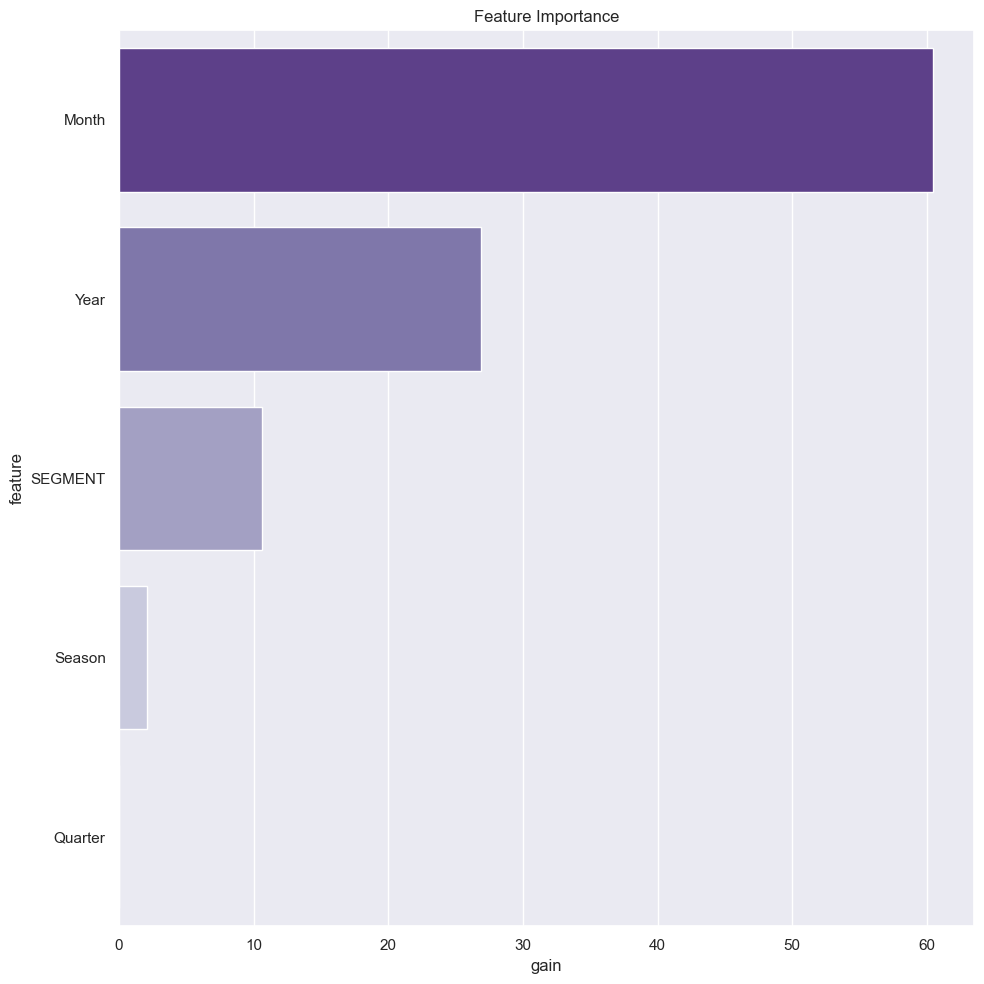

In [44]:
plot_lgb_importances(first_model, plot=True, num=30)

## <span style="color: purple">2.4. Complete Light GBM</span> <a class="anchor" id="section_2_4"></a>


Now, we will try to improve the performance of the model acting upon **Feature selection**: we will try to add existing features that have not been used yet can help the model to better understand the data.

In [45]:
original_data.columns

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person'],
      dtype='object')

In [46]:
#We are going to create a new dataframe with the columns that we are going to use for the model
ts_complete_lgbm = original_data[['Week Code','Sales in value (€)', 'Province', 'holiday','SEGMENT','Month', 'Year', 'Season','population']]

In [47]:
#Group df by week code, store code, segment, month, year, season, province, quarter, holiday, mean temp, population and real price in volume, adding sales in value
ts_complete_lgbm = ts_complete_lgbm.groupby(['Week Code','SEGMENT','Month', 'Year', 'Season','Province', 'holiday','population'])['Sales in value (€)'].sum().reset_index().set_index("Week Code")

In [48]:
ts_complete_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55700 entries, 1 to 116
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SEGMENT             55700 non-null  object 
 1   Month               55700 non-null  int64  
 2   Year                55700 non-null  int64  
 3   Season              55700 non-null  object 
 4   Province            55700 non-null  object 
 5   holiday             55700 non-null  float64
 6   population          55700 non-null  int64  
 7   Sales in value (€)  55700 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 3.8+ MB


In [49]:
ts_complete_lgbm.head() 

SEGMENT  Month  Year  Season                         Province  \
Week Code                                                                   
1          ARTISANS      1  2021  Winter                            Alava   
1          ARTISANS      1  2021  Winter                         Albacete   
1          ARTISANS      1  2021  Winter                         Alicante   
1          ARTISANS      1  2021  Winter  Area Metropolitana de Barcelona   
1          ARTISANS      1  2021  Winter     Area Metropolitana de Madrid   

           holiday  population  Sales in value (€)  
Week Code                                           
1              1.0      251833                9.24  
1              1.0      299296               26.72  
1              1.0     1478447              118.79  
1              1.0     1303135              956.92  
1              1.0     1468540             1586.79

In [50]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in ts_complete_lgbm.columns:
    col_type = ts_complete_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        ts_complete_lgbm[c] = ts_complete_lgbm[c].astype('category')

In [51]:
#Change type od holiday to boolean
ts_complete_lgbm['holiday'] = ts_complete_lgbm['holiday'].astype('bool')

In [52]:
#Reset index to make "Week Code" a regular column
ts_complete_lgbm = ts_complete_lgbm.reset_index()

#Sort DataFrame by "Week Code"
ts_complete_lgbm = ts_complete_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = ts_complete_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = ts_complete_lgbm[~ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = ts_complete_lgbm[ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in value (€)']
X_train = train[cols]
Y_train = train['Sales in value (€)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in value (€)']

In [53]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((51951, 7), (51951,), (3749, 7), (3749,))

In [54]:
train.head()

SEGMENT  Month  Year  Season                         Province  \
0        ARTISANS      1  2021  Winter                            Alava   
1        ARTISANS      1  2021  Winter                        Castellon   
2  IMPORT PREMIUM      1  2021  Winter                            Avila   
3        ARTISANS      1  2021  Winter                         Alicante   
4        ARTISANS      1  2021  Winter  Area Metropolitana de Barcelona   

   holiday  population  Sales in value (€)  
0     True      251833                9.24  
1     True      443161               25.64  
2     True      122086              560.74  
3     True     1478447              118.79  
4     True     1303135              956.92

In [55]:
#Train the LightGBM model
second_model = lgb.LGBMRegressor(random_state=384)
second_model.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val)))

TRAIN SMAPE: 44.19064975218182
VALID SMAPE: 41.72177616273884


It is performing pretty bad. Let's check feature importance for trying to improve the model in future sections.

In [56]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(second_model, num=50)

      feature       gain
1       Month  28.400000
4    Province  26.000000
0     SEGMENT  15.666667
6  population  13.633333
2        Year   6.633333
3      Season   5.066667
5     holiday   4.600000


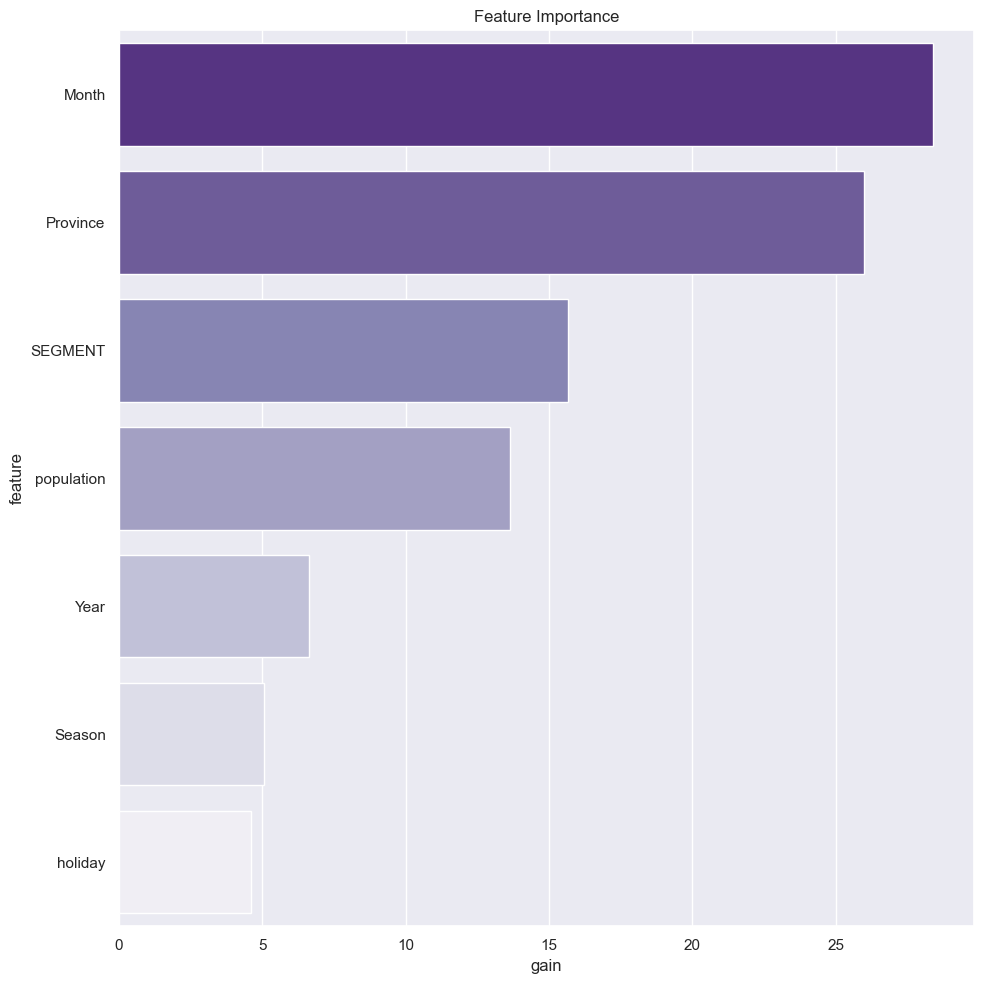

In [57]:
plot_lgb_importances(second_model, plot=True, num=30)

# <span style="color: purple">**3. Modeling for Manufacturer Demand Forecasting**</span> <a class="anchor" id="section_3"></a>

Now, we will follow the same steps as before, but this time we will predict sales for each manufacturer.

## <span style="color: purple">3.1. Simple Autoarima model</span> <a class="anchor" id="section_3_1"></a>

First, we will divide our data into train and test sets. Then we will fit a simple autoarima model to our data and plot the results.

In [58]:
#We get a copy of the df
ts_simple_autoarima = ts_simple_data.copy()

In [59]:
#We do the preparations for having a dataset suitable to be used by the autoarima function
ts_simple_autoarima = ts_simple_autoarima.set_index('Week Code')
ts_simple_autoarima = ts_simple_autoarima.drop(['Month', 'Year', 'Season', 'Quarter'], axis=1)

ts_simple_autoarima_manufacturer = ts_simple_autoarima.drop(['SEGMENT'], axis=1)
ts_simple_autoarima_manufacturer= ts_simple_autoarima_manufacturer.groupby(['Week Code', 'MANUFACTURER'])['Sales in value (€)'].sum().reset_index()

In [60]:
ts_simple_autoarima_manufacturer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           812 non-null    int64  
 1   MANUFACTURER        812 non-null    object 
 2   Sales in value (€)  812 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 19.2+ KB


In [61]:
ts_simple_autoarima_manufacturer = ts_simple_autoarima_manufacturer.set_index('Week Code')

In [62]:
#On this snippet of code, we will train the AutoARIMA model for each manufacturer and store the model in a dictionary. We will comment each step to facilitate its understanding and replication.

#We create a dictionary to store the models and the data for each manufacturer
manufacturer_models = {}
manufacturer_data_dict = {}

#We get the unique manufacturer
unique_manufacturer = ts_simple_autoarima_manufacturer['MANUFACTURER'].unique()

for manufacturer in unique_manufacturer:
    #Extract the data for the manufacturer we are working on
    segment_data = ts_simple_autoarima_manufacturer[ts_simple_autoarima_manufacturer['MANUFACTURER'] == manufacturer]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(segment_data['Sales in value (€)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    manufacturer_data_dict[manufacturer] = {'train': train_data, 'val': val_data}

    #Fit the AutoARIMA model to the train set and store it in the dictionary
    model = auto_arima(train_data)
    manufacturer_models[manufacturer] = model


In [63]:
#We take a look at the models created for each manufacturer
for manufacturer, model in manufacturer_models.items():
    print(f"manufacturer: {manufacturer}")
    print(model.summary())
    print("-------------------")

manufacturer: MANUFACTURER 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1312.165
Date:                Sun, 02 Jul 2023   AIC                           2630.331
Time:                        19:49:07   BIC                           2638.432
Sample:                             0   HQIC                          2633.617
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.536e+04   1.76e+04      3.715      0.000    3.09e+04    9.98e+04
ar.L1          0.7466      0.060     12.537      0.000       0.630       0.863
sigma2       1.33e+09  

In [64]:
#Let's check that our validation data has been stored correctly
for manufacturer, data in manufacturer_data_dict.items():
    print(f"Manufacturer: {manufacturer}")
    print(data['val'])
    print("-------------------")

Manufacturer: MANUFACTURER 1
Week Code
111    213508.03
112    221342.22
113    239838.02
114    281165.30
115    249153.84
116    268176.74
Name: Sales in value (€), dtype: float64
-------------------
Manufacturer: MANUFACTURER 2
Week Code
111    499378.08
112    560155.14
113    586855.39
114    654629.90
115    586947.67
116    567863.33
Name: Sales in value (€), dtype: float64
-------------------
Manufacturer: MANUFACTURER 3
Week Code
111     902041.76
112     882404.72
113     857053.45
114    1028560.75
115    1016153.52
116    1042028.29
Name: Sales in value (€), dtype: float64
-------------------
Manufacturer: MANUFACTURER 4
Week Code
111    188400.18
112    148616.71
113    139321.88
114    152865.81
115    154015.44
116    157148.75
Name: Sales in value (€), dtype: float64
-------------------
Manufacturer: MANUFACTURER 5
Week Code
111    53751.78
112    60075.78
113    63411.75
114    69772.36
115    68802.92
116    69449.95
Name: Sales in value (€), dtype: float64
----------

In [65]:
#So, after training our model in our train set, we can use it to make predictions on the validation set. We will store the predictions in a new DataFrame and add it to the dictionary. Also here, the code will be commented in detail to facilitate its understanding and replication.

#We will apply the model to the validation set of each manufacturer
for manufacturer, model in manufacturer_models.items():
    #Extract the validation data for the manufacturer
    val_data = manufacturer_data_dict[manufacturer]['val']

    #Apply the model to the validation data and store the predictions
    predictions = model.predict(n_periods=len(val_data)+1)

    #Create a new DataFrame to store the predictions with the correct index ad then, store it in the dictionary
    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])
    manufacturer_data_dict[manufacturer]['predictions'] = predictions_df

#Print the predictions for each manufacturer
for manufacturer, data in manufacturer_data_dict.items():
    print(f"manufacturer: {manufacturer}")
    print(data['predictions'])
    print("-------------------")

manufacturer: MANUFACTURER 1
             Predictions
Week Code               
111        233022.619610
112        239326.798118
113        244033.282371
114        247546.982689
115        250170.191279
116        252128.589174
-------------------
manufacturer: MANUFACTURER 2
             Predictions
Week Code               
111        636873.476749
112        656855.229684
113        673777.964021
114        688109.986760
115        700247.911501
116        710527.634028
-------------------
manufacturer: MANUFACTURER 3
            Predictions
Week Code              
111        9.909530e+05
112        1.018223e+06
113        1.038370e+06
114        1.053254e+06
115        1.064251e+06
116        1.072376e+06
-------------------
manufacturer: MANUFACTURER 4
             Predictions
Week Code               
111        171172.897689
112        171172.897689
113        171172.897689
114        171172.897689
115        171172.897689
116        171172.897689
-------------------
manufacturer

In [66]:
#After applying our trained autoarima models for each manufacturer to each validation set, we should check how are they performing. For that, we will calculate the MSE and MAPE for each manufacturer model. We will also comment each step to facilitate its understanding and replication.

#We create the function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#We initialize 2 list which will store the errors for each of the manufacturer' models
mse_list_man = []
mape_list_man = []

#We make an iteration over each manufacturer
for manufacturer in manufacturer_data_dict.keys():

    #First we get the true values of the validation set, which we stored in the dictionary
    y_true = manufacturer_data_dict[manufacturer]['val']
    
    #Then, we get the predictions of the validation set after applying the model
    y_pred = manufacturer_data_dict[manufacturer]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_man.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_man.append(mape)

    #Print the results for each manufacturer
    print(f"manufacturer: {manufacturer}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

manufacturer: MANUFACTURER 1
MSE: 351771976.2924525
MAPE: 6.2272155056103236%
-------------------
manufacturer: MANUFACTURER 2
MSE: 11687064987.342888
MAPE: 18.191441465720914%
-------------------
manufacturer: MANUFACTURER 3
MSE: 10511900240.616661
MAPE: 9.408453187503401%
-------------------
manufacturer: MANUFACTURER 4
MSE: 441042119.858586
MAPE: 13.20383361429934%
-------------------
manufacturer: MANUFACTURER 5
MSE: 43843632.37238174
MAPE: 9.013387964017376%
-------------------
manufacturer: MANUFACTURER 6
MSE: 7215848832.262723
MAPE: 29.396978270594182%
-------------------
manufacturer: OTHER MANUFACTURERS
MSE: 40493027.56393213
MAPE: 4.261253227238882%
-------------------


Let's take a look at the results:

**MANUFACTURER 1**:
MAPE: **6.27%**
The MAPE is relatively low, suggesting that the model performs reasonably well in predicting sales for this manufacturer.

**MANUFACTURER 2**:
MAPE: **18.19%**
The MAPE is high, suggesting that the model performs poorly in predicting sales for this manufacturer.

**MANUFACTURER 3**:
MAPE: **9.41%**
The MAPE is acceptable, but it can be improved.

**MANUFACTURER 4**:
MAPE: **13.2%**
The MAPE is acceptable, but it can be improved.

**MANUFACTURER 5**:
MAPE: **9.01%**
The MAPE is acceptable, but it can be improved

**MANUFACTURER 6**:
MAPE: **29.40%**
The MAPE is really high, suggesting that the model performs poorly in predicting sales for this manufacturer.

**OTHER MANUFACTURERS**:
MAPE: **4.26%**
The MAPE is relatively low, suggesting that the model performs reasonably well in predicting sales for this manufacturer.

**Again, we can see that the model is, overall, performing better than the ones obtained in the notebook part 4.1**

## <span style="color: purple">3.2. Autoarima model with hyperparameter tuning</span> <a class="anchor" id="section_3_2"></a>

As we have seen, the simple Autoarima model can be used to predict sales for some manufacturers, but it does not perform well for others. So, we will try to improve the performance of the model by tuning the hyperparameters.

In [67]:
#The code that we will present here will be simmilar than the one we used for the simple AutoARIMA model. The main difference is that we will use a grid search to find the best hyperparameters for each manufacturer. We will comment each step to facilitate its understanding and replication.

#We create 2 new dictionaries, just to avoid potential overlappings with the previous ones
manufacturer_models_2 = {}
manufacturer_data_dict_2 = {}

#We get the unique manufacturers
unique_manufacturers = ts_simple_autoarima_manufacturer['MANUFACTURER'].unique()

for manufacturer in unique_manufacturers:
    #Extract the data for the manufacturer we are working on
    manufacturer_data = ts_simple_autoarima_manufacturer[ts_simple_autoarima_manufacturer['MANUFACTURER'] == manufacturer]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(manufacturer_data['Sales in value (€)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    manufacturer_data_dict_2[manufacturer] = {'train': train_data, 'val': val_data}

    #Now, and this is the new part, we will prepare a list of hyperparameters to test
    p_values = [0, 1, 2, 3, 4]  #Different values for the AR order (p)
    d_values = [0, 1, 2] #Different values for the I order (d)
    q_values = [0, 1, 2, 3, 4] #Different values for the MA order (q)
    param_combinations = list(product(p_values, d_values, q_values))

    #We initialize the best model as None and best RMSE to infinity
    best_model = None
    best_rmse = np.inf

    #We perform grid search over the hyperparameter combinations
    for params in param_combinations:
        p, d, q = params

        #Fit the AutoARIMA model to the train set using the current hyperparameters
        model = auto_arima(train_data, start_p=p, d=d, start_q=q)

        #Make the predictions on the validation set
        forecast = model.predict(len(val_data))

        #Calculate root mean squared error (RMSE) for the validation set
        rmse = np.sqrt(mean_squared_error(val_data, forecast))

        #Update the best model if the current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model

    #Store the best model for each manufacturer in the dictionary
    manufacturer_models_2[manufacturer] = best_model

In [258]:
#We take a look at the best models found for each manufacturer
for manufacturer, best_model in manufacturer_models_2.items():
    print(f"manufacturer: {manufacturer}")
    print(best_model.summary())
    print("-------------------")

manufacturer: MANUFACTURER 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1274.125
Date:                Sat, 01 Jul 2023   AIC                           2556.250
Time:                        17:51:26   BIC                           2567.052
Sample:                             0   HQIC                          2560.631
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.48e+04   1.27e+04      2.745      0.006    9949.570    5.96e+04
ar.L1          0.6381      0.075      8.486      0.000       0.491       0.785
ar.L2          0.1421  

In [259]:
#We will apply the model to the validation set of each manufacturer so, as we have done in the autoarima model, we take a look at the validation set for each manufacturer
for manufacturer, data in manufacturer_data_dict_2.items():
    print(f"manufacturer: {manufacturer}")
    print(data['val'])
    print("-------------------")

manufacturer: MANUFACTURER 1
Week Code
111    127255
112    127581
113    144440
114    172192
115    151905
116    167928
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 2
Week Code
111    376132
112    405392
113    437342
114    489176
115    453308
116    433727
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 3
Week Code
111    689318
112    641325
113    616401
114    735045
115    799914
116    830607
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 4
Week Code
111    113876
112     81271
113     73972
114     80578
115     83612
116     86344
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 5
Week Code
111    28945
112    32657
113    34991
114    39110
115    37487
116    37778
Name: Sales in volume (Lt), dtype: int64
-------------------
manufacturer: MANUFACTURER 6
Week Code
111    869785
112    552573
113    332278
114  

In [260]:
#This is exactly the same code as we used for the simple AutoARIMA model, but applying the best model found. We will apply the best model to the validation set of each manufacturer and store the predictions in the dictionary.

for manufacturer, best_model in manufacturer_models_2.items():
    
    val_data = manufacturer_data_dict_2[manufacturer]['val']

    predictions = best_model.predict(n_periods=len(val_data)+1)

    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])

    manufacturer_data_dict_2[manufacturer]['predictions'] = predictions_df

#Print predictions of each manufacturer
for manufacturer, data in manufacturer_data_dict_2.items():
    print(f"Manufacturer: {manufacturer}")
    print(data['predictions'])
    print("-------------------")

Manufacturer: MANUFACTURER 1
             Predictions
Week Code               
111        137381.128650
112        141314.693346
113        144487.514214
114        147070.963656
115        149170.250556
116        150876.856630
-------------------
Manufacturer: MANUFACTURER 2
             Predictions
Week Code               
111        401607.228491
112        409536.977833
113        423210.106547
114        434481.193298
115        443772.219456
116        451431.034350
-------------------
Manufacturer: MANUFACTURER 3
             Predictions
Week Code               
111        692061.677944
112        694596.016916
113        697130.355887
114        699664.694859
115        702199.033831
116        704733.372803
-------------------
Manufacturer: MANUFACTURER 4
            Predictions
Week Code              
111        90700.264993
112        87676.195845
113        89943.621367
114        89516.588550
115        86947.414276
116        85238.626793
-------------------
Manufacturer

In [261]:
#We will initialize lists to store MSE and MAPE for each manufacturer
mse_list_man_2 = []
mape_list_man_2 = []

#Iterate over each manufacturer
for manufacturer in manufacturer_data_dict_2.keys():

    # Get the true values from the validation set
    y_true = manufacturer_data_dict_2[manufacturer]['val']
    
    # Get the predicted values from the predictions DataFrame
    y_pred = manufacturer_data_dict_2[manufacturer]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_man_2.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_man_2.append(mape)

    #Print the results for each manufacturer
    print(f"manufacturer: {manufacturer}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

manufacturer: MANUFACTURER 1
MSE: 203406980.6156443
MAPE: 7.549674289083237%
-------------------
manufacturer: MANUFACTURER 2
MSE: 710294057.248967
MAPE: 4.732194875613879%
-------------------
manufacturer: MANUFACTURER 3
MSE: 6001118090.471604
MAPE: 8.997461215997243%
-------------------
manufacturer: MANUFACTURER 4
MSE: 154246519.93191427
MAPE: 11.031149049509008%
-------------------
manufacturer: MANUFACTURER 5
MSE: 7861220.36734461
MAPE: 7.585755348476915%
-------------------
manufacturer: MANUFACTURER 6
MSE: 8032771653.687619
MAPE: 18.379138114475943%
-------------------
manufacturer: OTHER MANUFACTURERS
MSE: 8652933.57858587
MAPE: 5.27560930940966%
-------------------


So, let's take a look to the errors of the new models:
- **MANUFACTURER 5**: 
MAPE: **7.59** 
MAPE has decreased (previous one 9.01%), so we can say that the model performs better in predicting sales for this manufacturer.

- **MANUFACTURER 4**:
MAPE: **11.19%**
MAPE has decreased (previous one 13.2%), so we can say that the model performs better in predicting sales for this manufacturer.

- **MANUFACTURER 2**:
MAPE: **4.73%**
Mape has decreased significantly (previous one 18.19%), so we can say that the model performs much better in predicting sales for this manufacturer.

- **MANUFACTURER 3**:
MAPE: **8.99%**
MAPE has also decreased (previous one 9.41%), so we can say that the model performs better in predicting sales for this manufacturer.

- **MANUFACTURER 1 and OTHER MANUFACTURERS**:
MAPE: **7.55%** and **5.28%**
MAPE has increased so we can say that the model performs worse in predicting sales for these manufacturers

- **MANUFACTURER 6**:
MAPE: **18.38%**
MAPE has decreased significantly (previous one 29.39%), so we can say that the model performs much better in predicting sales for this manufacturer.

The conclusions that we can draw from this are simmilar to the segment models. Overall, these last models are performing better than the simple Autoarima model, so we can say that they are **potential good models to predict sales for all manufacturers** despite, as we know, they can be improved for some manufacturers (specially Manufacturer 6)

## <span style="color: purple">3.3. Simple LightGBM</span> <a class="anchor" id="section_3_3"></a>

Now, instead of applying an ARIMA type model, we will apply a LightGBM model. At this point, we will apply the simplest one

In [81]:
#We create a copy
ts_simple_lgbm = ts_simple_data.copy()

In [82]:
ts_simple_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           6702 non-null   int64  
 1   SEGMENT             6702 non-null   object 
 2   MANUFACTURER        6702 non-null   object 
 3   Month               6702 non-null   int64  
 4   Year                6702 non-null   int64  
 5   Season              6702 non-null   object 
 6   Quarter             6702 non-null   int64  
 7   Sales in value (€)  6702 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 419.0+ KB


In [83]:
#Drop manufacturer column, and group sales in value
ts_simple_lgbm = ts_simple_lgbm.drop(['SEGMENT'], axis=1)

manufacturer_sales_lgbm= ts_simple_lgbm.groupby(['Week Code', 'MANUFACTURER', 'Month', 'Year', 'Season', 'Quarter'])['Sales in value (€)'].sum().reset_index().set_index("Week Code")

In [84]:
#We convert the categorical variables to the category type
for c in manufacturer_sales_lgbm.columns:
    col_type = manufacturer_sales_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        manufacturer_sales_lgbm[c] = manufacturer_sales_lgbm[c].astype('category')

In [85]:
manufacturer_sales_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812 entries, 1 to 116
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   MANUFACTURER        812 non-null    category
 1   Month               812 non-null    int64   
 2   Year                812 non-null    int64   
 3   Season              812 non-null    category
 4   Quarter             812 non-null    int64   
 5   Sales in value (€)  812 non-null    float64 
dtypes: category(2), float64(1), int64(3)
memory usage: 33.9 KB


In [86]:
manufacturer_sales_lgbm.head()

MANUFACTURER  Month  Year  Season  Quarter  Sales in value (€)
Week Code                                                                  
1          MANUFACTURER 1      1  2021  Winter        1           195122.16
1          MANUFACTURER 2      1  2021  Winter        1           529572.53
1          MANUFACTURER 3      1  2021  Winter        1           768081.25
1          MANUFACTURER 4      1  2021  Winter        1           125312.57
1          MANUFACTURER 5      1  2021  Winter        1            46182.27

In [87]:
#Reset index to make "Week Code" a regular column
manufacturer_sales_lgbm = manufacturer_sales_lgbm.reset_index()

#Sort DataFrame by "Week Code"
manufacturer_sales_lgbm = manufacturer_sales_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = manufacturer_sales_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = manufacturer_sales_lgbm[~manufacturer_sales_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = manufacturer_sales_lgbm[manufacturer_sales_lgbm['Week Code'].isin(last_week_codes)]

#Drop the "Week Code" column
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in value (€)']
X_train = train[cols]
Y_train = train['Sales in value (€)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in value (€)']

In [88]:
train.head()

MANUFACTURER  Month  Year  Season  Quarter  Sales in value (€)
0  MANUFACTURER 1      1  2021  Winter        1           195122.16
1  MANUFACTURER 2      1  2021  Winter        1           529572.53
2  MANUFACTURER 3      1  2021  Winter        1           768081.25
3  MANUFACTURER 4      1  2021  Winter        1           125312.57
4  MANUFACTURER 5      1  2021  Winter        1            46182.27

In [89]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((756,), (756, 5), (56,), (56, 5))

At this point, what we have are 756 training examples with 5 features, and 56 validation examples with the same 5 features. The target variable have the same shape as the features, but with only one column (sales volume)

In [90]:
#Train the LightGBM model
first_model_man = lgb.LGBMRegressor(random_state=384)
first_model_man.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, first_model_man.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model_man.predict(X_val)))

TRAIN SMAPE: 12.657546911003248
VALID SMAPE: 18.218913140714182


This model is working pretty well (huge difference for the Volume situation), so it can be a potential model to use for predicting sales for all manufacturers.

In [91]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model_man, num=50)

        feature       gain
1         Month  60.236822
2          Year  28.762414
0  MANUFACTURER   8.785332
3        Season   2.215432
4       Quarter   0.000000


In [92]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((5, 2), (4, 2), (4, 2))

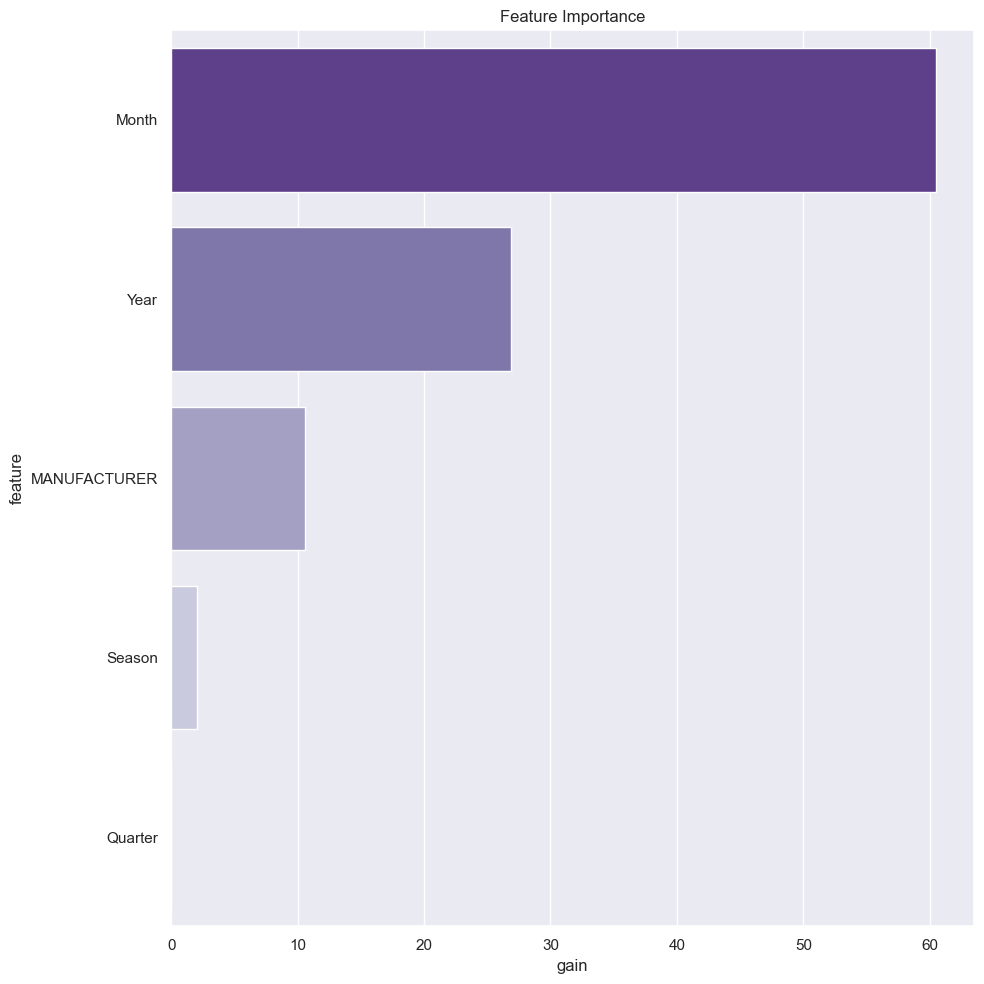

In [93]:
plot_lgb_importances(first_model, plot=True, num=30)

## <span style="color: purple">3.4. Complete Light GBM</span> <a class="anchor" id="section_3_4"></a>

Now, we will try to improve the performance of the model acting upon **Feature selection**: we will try to add existing features that have not been used yet can help the model to better understand the data.

In [94]:
original_data.columns

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person'],
      dtype='object')

In [96]:
#We are going to create a new dataframe with the columns that we are going to use for the model
ts_complete_lgbm = original_data[['Week Code','Sales in value (€)', 'holiday','MANUFACTURER','Month','mean temp','Season']]

In [97]:
#Group df by week code, store code, segment, month, year, season, province, quarter, holiday, mean temp, population and real price in volume, adding sales in value
ts_complete_lgbm = ts_complete_lgbm.groupby(['Week Code','MANUFACTURER','Month','holiday','Season', 'mean temp'])['Sales in value (€)'].sum().reset_index().set_index("Week Code")

In [98]:
ts_complete_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36680 entries, 1 to 116
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MANUFACTURER        36680 non-null  object 
 1   Month               36680 non-null  int64  
 2   holiday             36680 non-null  float64
 3   Season              36680 non-null  object 
 4   mean temp           36680 non-null  float64
 5   Sales in value (€)  36680 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB


In [99]:
ts_complete_lgbm.head() 

MANUFACTURER  Month  holiday  Season  mean temp  \
Week Code                                                      
1          MANUFACTURER 1      1      0.0  Winter  11.685714   
1          MANUFACTURER 1      1      1.0  Winter   5.485714   
1          MANUFACTURER 1      1      1.0  Winter   5.500000   
1          MANUFACTURER 1      1      1.0  Winter   6.000000   
1          MANUFACTURER 1      1      1.0  Winter   6.028571   

           Sales in value (€)  
Week Code                      
1                     8139.76  
1                       21.68  
1                       76.57  
1                       25.38  
1                     1501.53

In [100]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in ts_complete_lgbm.columns:
    col_type = ts_complete_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        ts_complete_lgbm[c] = ts_complete_lgbm[c].astype('category')

In [101]:
#Change type od holiday to boolean
ts_complete_lgbm['holiday'] = ts_complete_lgbm['holiday'].astype('bool')

In [102]:
#Reset index to make "Week Code" a regular column
ts_complete_lgbm = ts_complete_lgbm.reset_index()

#Sort DataFrame by "Week Code"
ts_complete_lgbm = ts_complete_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = ts_complete_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = ts_complete_lgbm[~ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = ts_complete_lgbm[ts_complete_lgbm['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in value (€)']
X_train = train[cols]
Y_train = train['Sales in value (€)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in value (€)']

In [103]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((34185, 5), (34185,), (2495, 5), (2495,))

In [104]:
train.head()

MANUFACTURER  Month  holiday  Season  mean temp  Sales in value (€)
0  MANUFACTURER 1      1    False  Winter  11.685714             8139.76
1  MANUFACTURER 1      1     True  Winter   6.514286              151.55
2  MANUFACTURER 1      1     True  Winter   5.485714               21.68
3  MANUFACTURER 4      1     True  Winter   9.142857              241.88
4  MANUFACTURER 1      1     True  Winter   6.000000               25.38

In [105]:
#Train the LightGBM model
second_model_man = lgb.LGBMRegressor(random_state=384)
second_model_man.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, second_model_man.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, second_model_man.predict(X_val)))

TRAIN SMAPE: 101.50864590165908
VALID SMAPE: 100.68932292672802


We have been trying to add and drop features of the model the result has been quite horrible. Despite that, we have decided to keep it a really bad model to also help us on future iterations, allowing us to further understand variables importance.

In [106]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(second_model_man, num=50)

        feature       gain
4     mean temp  62.666667
1         Month  20.666667
0  MANUFACTURER   9.100000
2       holiday   6.000000
3        Season   1.566667


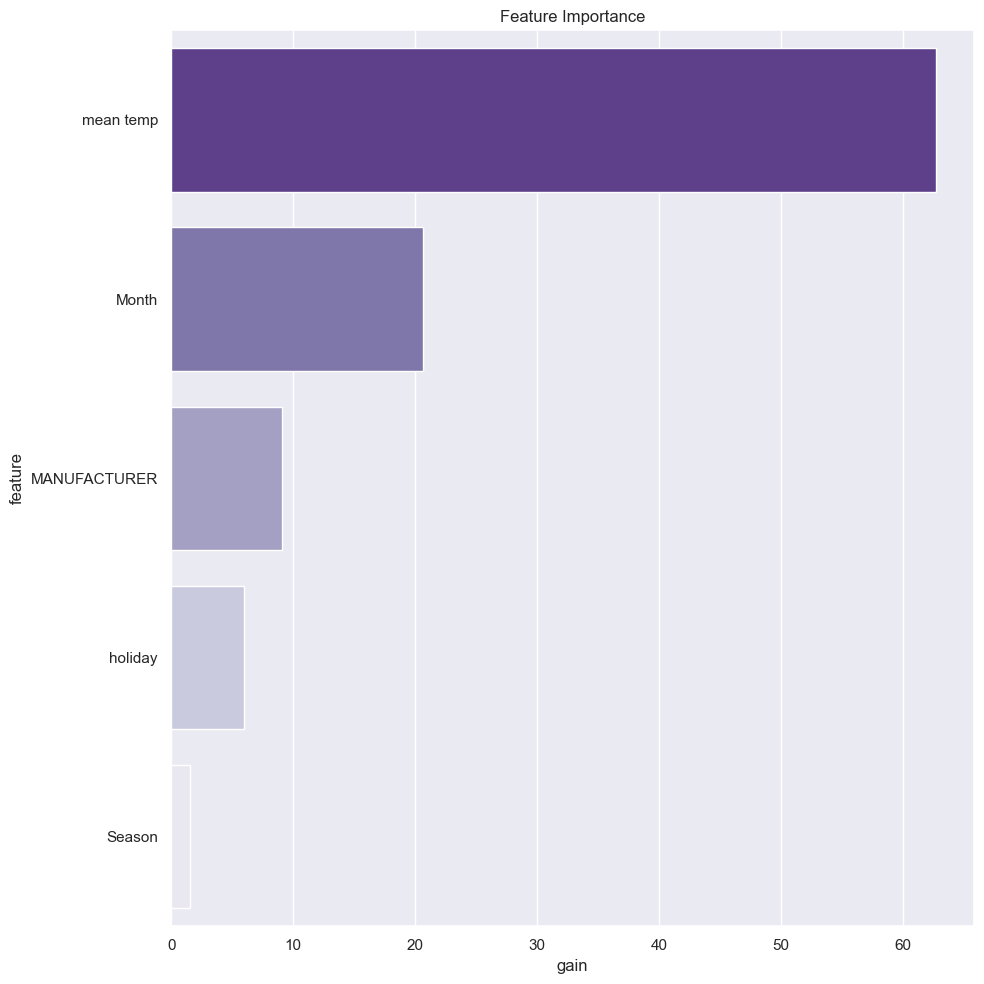

In [107]:
plot_lgb_importances(second_model_man, plot=True, num=30)

# <span style="color: purple">**4. Modeling for Stores Demand Forecasting**</span> <a class="anchor" id="section_4"></a>

Despite it is not require for the challenge, we will try to predict sales for each store considering also segments and manufacturers (so it is like applying the previous things done but altogether). We will apply just LightGBM models, due to the fact that for the multiple time series ARIMA models we have to iterate over all the stores and segments, and it would be really inefficient. **Also, we have decided to apply LightGBM because it has performed poorly trying to predict sales for manufacturers and for segments separately, so we like to see if it performs better when we try to predict sales for all of them together.**

## <span style="color: purple">4.1. LightGBM</span> <a class="anchor" id="section_4_1"></a>

In [288]:
original_data.columns

Index(['Store Code', 'Week Code', 'Product Code', 'Sales in units',
       'Sales in value (€)', 'Sales in volume (Lt)', 'Number of references',
       'Real price in units', 'Real price in volume', 'Rate price in units',
       'Rate price in volume', 'Month', 'Year', 'Season', 'Quarter',
       'channel_code', 'province code', 'postal_code',
       'sales_surface_sqmeters', 'Province', 'Autonomus Community', 'Channel',
       'SEGMENT', 'MANUFACTURER', 'BRAND', 'PACKAGING', 'VOLUME', 'UNITS',
       'min temp', 'max temp', 'mean temp', 'precipitation', 'promotion',
       'holiday', 'population', 'liters/person'],
      dtype='object')

In [109]:
#We are going to create a new dataframe with the columns that we are going to use for the model
stores_lgbm = original_data[['Week Code','Store Code','Province', 'Sales in value (€)', 'holiday','SEGMENT','Month','mean temp','precipitation','liters/person', 'MANUFACTURER']]

In [110]:
#Group and add sales
stores_lgbm = stores_lgbm.groupby(['Week Code','Store Code','Month', 'Province','holiday','SEGMENT', 'precipitation',  'mean temp', 'MANUFACTURER'])['liters/person','Sales in value (€)'].sum().reset_index().set_index("Week Code")

In [111]:
stores_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284464 entries, 1 to 116
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Store Code          1284464 non-null  int64  
 1   Month               1284464 non-null  int64  
 2   Province            1284464 non-null  object 
 3   holiday             1284464 non-null  float64
 4   SEGMENT             1284464 non-null  object 
 5   precipitation       1284464 non-null  float64
 6   mean temp           1284464 non-null  float64
 7   MANUFACTURER        1284464 non-null  object 
 8   liters/person       1284464 non-null  float64
 9   Sales in value (€)  1284464 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 107.8+ MB


In [112]:
stores_lgbm.head() 

Store Code  Month Province  holiday    SEGMENT  precipitation  \
Week Code                                                                  
1                   1      1  Almeria      1.0    CELIACS       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0  FLAVOURED       0.585714   

           mean temp    MANUFACTURER  liters/person  Sales in value (€)  
Week Code                                                                
1          12.571429  MANUFACTURER 1       0.000000                0.95  
1          12.571429  MANUFACTURER 1       0.000018               22.63  
1          12.571429  MANUFACTURER 3       0.000040               56.00  
1          12.571429  MANUFACTURER 6       0.000016               11.20  
1          12.571429  MANUFACTURER 2       0.000029               22.44

In [113]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in stores_lgbm.columns:
    col_type = stores_lgbm[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        stores_lgbm[c] = stores_lgbm[c].astype('category')

In [114]:
#Change type od holiday to boolean
stores_lgbm['holiday'] = stores_lgbm['holiday'].astype('bool')

In [115]:
#Reset index to make "Week Code" a regular column
stores_lgbm = stores_lgbm.reset_index()

#Sort DataFrame by "Week Code"
stores_lgbm = stores_lgbm.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = stores_lgbm['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = stores_lgbm[~stores_lgbm['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = stores_lgbm[stores_lgbm['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in value (€)']
X_train = train[cols]
Y_train = train['Sales in value (€)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in value (€)']

In [116]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1193690, 9), (1193690,), (90774, 9), (90774,))

In [117]:
train.head()

Store Code  Month Province  holiday    SEGMENT  precipitation  mean temp  \
0           1      1  Almeria     True    CELIACS       0.585714  12.571429   
1           1      1  Almeria     True      EXTRA       0.585714  12.571429   
2           1      1  Almeria     True      EXTRA       0.585714  12.571429   
3           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   
4           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   

     MANUFACTURER  liters/person  Sales in value (€)  
0  MANUFACTURER 1       0.000000                0.95  
1  MANUFACTURER 3       0.000040               56.00  
2  MANUFACTURER 6       0.000016               11.20  
3  MANUFACTURER 2       0.000029               22.44  
4  MANUFACTURER 3       0.000040               11.94

In [118]:
#Train the LightGBM model
model_stores = lgb.LGBMRegressor(random_state=384)
model_stores.fit(X_train, Y_train, eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

#Evaluate the model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, model_stores.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, model_stores.predict(X_val)))

TRAIN SMAPE: 39.87839509043773
VALID SMAPE: 40.78186364544191


In [119]:
#Get the model parameters
model_stores.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 384,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

After many iterations, this is the best model that we have been able to found. It is not working bad, but it is not good enough. After checking the importance of the features we will apply hyperparameter tuning to try to try to improve the performance of the model.

In [120]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': X_train.columns,
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        palette = sns.color_palette("Purples_r", n_colors=len(feat_imp.head(25)))
        sns.barplot(x="gain", y="feature", data=feat_imp.head(25), palette=palette)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(model_stores, num=50)

         feature       gain
8  liters/person  24.600000
2       Province  19.566667
6      mean temp  14.500000
0     Store Code   9.333333
7   MANUFACTURER   9.300000
1          Month   9.266667
5  precipitation   7.866667
4        SEGMENT   4.533333
3        holiday   1.033333


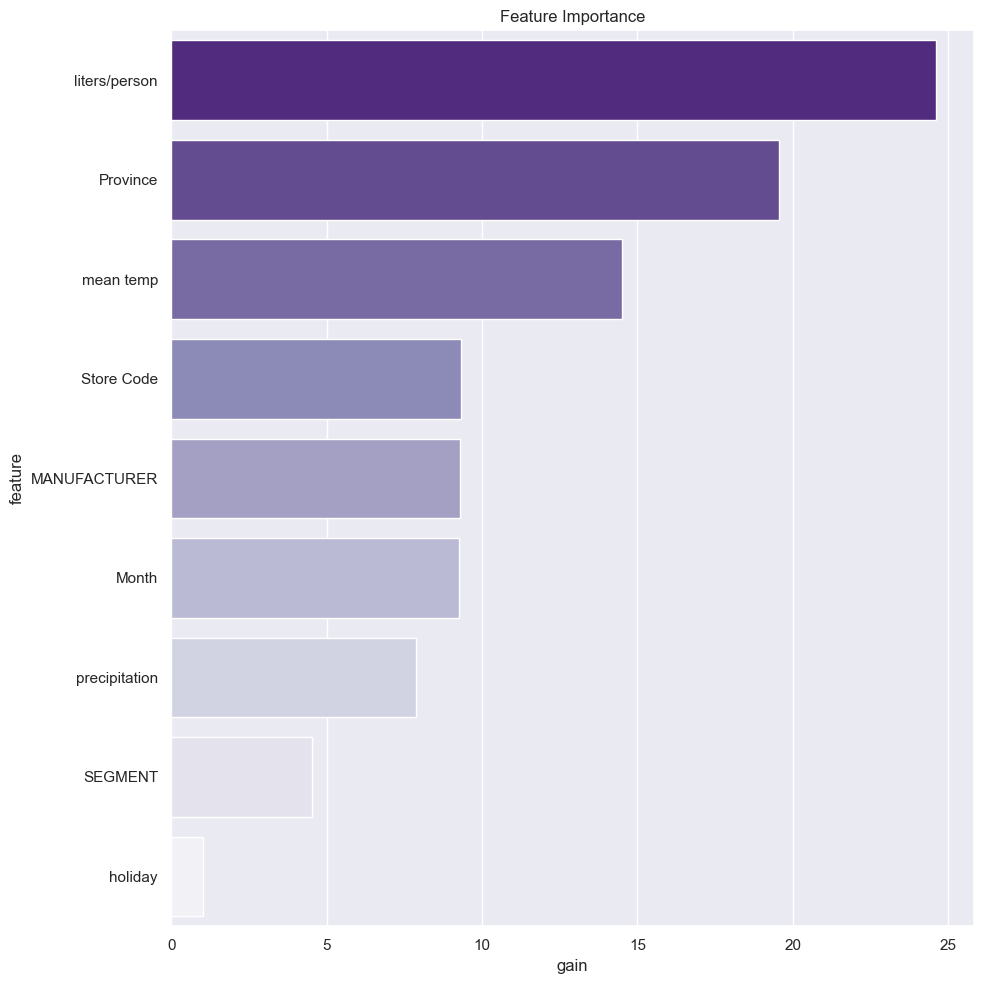

In [121]:
plot_lgb_importances(model_stores, plot=True, num=30)

## <span style="color: purple">4.2. LightGBM with Finetuning</span> <a class="anchor" id="section_4_2"></a>

At this section we are going to try to improve the model for the already selected data, applying hyperparameter tuning. We will use the same data as before, but we will try to find the best hyperparameters for our model.

In [122]:
#We are going to create a new dataframe with the columns that we are going to use for the model
stores_lgbm_finetuning = original_data[['Week Code','Store Code','Province', 'Sales in value (€)', 'holiday','SEGMENT','Month','mean temp','precipitation','liters/person', 'MANUFACTURER']]

In [123]:
#Group and add sales
stores_lgbm_finetuning = stores_lgbm_finetuning.groupby(['Week Code','Store Code','Month', 'Province','holiday','SEGMENT', 'precipitation',  'mean temp', 'MANUFACTURER'])['liters/person','Sales in value (€)'].sum().reset_index().set_index("Week Code")

In [124]:
stores_lgbm_finetuning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284464 entries, 1 to 116
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Store Code          1284464 non-null  int64  
 1   Month               1284464 non-null  int64  
 2   Province            1284464 non-null  object 
 3   holiday             1284464 non-null  float64
 4   SEGMENT             1284464 non-null  object 
 5   precipitation       1284464 non-null  float64
 6   mean temp           1284464 non-null  float64
 7   MANUFACTURER        1284464 non-null  object 
 8   liters/person       1284464 non-null  float64
 9   Sales in value (€)  1284464 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 107.8+ MB


In [126]:
stores_lgbm_finetuning.head() 

Store Code  Month Province  holiday    SEGMENT  precipitation  \
Week Code                                                                  
1                   1      1  Almeria      1.0    CELIACS       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0      EXTRA       0.585714   
1                   1      1  Almeria      1.0  FLAVOURED       0.585714   

           mean temp    MANUFACTURER  liters/person  Sales in value (€)  
Week Code                                                                
1          12.571429  MANUFACTURER 1       0.000000                0.95  
1          12.571429  MANUFACTURER 1       0.000018               22.63  
1          12.571429  MANUFACTURER 3       0.000040               56.00  
1          12.571429  MANUFACTURER 6       0.000016               11.20  
1          12.571429  MANUFACTURER 2       0.000029               22.44

In [127]:
#For working with LightGBM we need to convert the categorical variables to type category
for c in stores_lgbm_finetuning.columns:
    col_type = stores_lgbm_finetuning[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        stores_lgbm_finetuning[c] = stores_lgbm_finetuning[c].astype('category')

In [128]:
#Change type od holiday to boolean
stores_lgbm_finetuning['holiday'] = stores_lgbm_finetuning['holiday'].astype('bool')

In [129]:
#Reset index to make "Week Code" a regular column
stores_lgbm_finetuning = stores_lgbm_finetuning.reset_index()

#Sort DataFrame by "Week Code"
stores_lgbm_finetuning = stores_lgbm_finetuning.sort_values('Week Code')

#Get the last 8 unique week codes
last_week_codes = stores_lgbm_finetuning['Week Code'].unique()[-8:]

#Create training set (all rows except the last 8 week codes)
train = stores_lgbm_finetuning[~stores_lgbm_finetuning['Week Code'].isin(last_week_codes)]

#Create validation set (last 8 week codes)
val = stores_lgbm_finetuning[stores_lgbm_finetuning['Week Code'].isin(last_week_codes)]

#We sort the dataframes by "Week Code" to make sure that the data is in the correct order
train = train.sort_values("Week Code").reset_index(drop = True)
val = val.sort_values("Week Code").reset_index(drop = True)

#Drop the "Week Code" column, as it will confuse the model
train = train.drop(['Week Code'], axis=1)
val = val.drop(['Week Code'], axis=1)

#Prepare the train set
cols = [col for col in train.columns if col != 'Sales in value (€)']
X_train = train[cols]
Y_train = train['Sales in value (€)']

#Prepare the test set
X_val = val[cols]
Y_val = val['Sales in value (€)']

In [130]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1193690, 9), (1193690,), (90774, 9), (90774,))

In [131]:
train.head()

Store Code  Month Province  holiday    SEGMENT  precipitation  mean temp  \
0           1      1  Almeria     True    CELIACS       0.585714  12.571429   
1           1      1  Almeria     True      EXTRA       0.585714  12.571429   
2           1      1  Almeria     True      EXTRA       0.585714  12.571429   
3           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   
4           1      1  Almeria     True  FLAVOURED       0.585714  12.571429   

     MANUFACTURER  liters/person  Sales in value (€)  
0  MANUFACTURER 1       0.000000                0.95  
1  MANUFACTURER 3       0.000040               56.00  
2  MANUFACTURER 6       0.000016               11.20  
3  MANUFACTURER 2       0.000029               22.44  
4  MANUFACTURER 3       0.000040               11.94

In [132]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

#Define the parameter grid for randomized search
param_grid = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [-1, 5, 10, 50],
    'num_leaves': [31, 50, 75, 100],
    'n_estimators': [100, 200, 300, 500],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'random_state': [42, 384, 999, 1234]
}


#Create an instance of the LightGBM regressor
finetuned_model = lgb.LGBMRegressor()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(finetuned_model, param_distributions=param_grid, cv=30, scoring=lgbm_smape)
random_search.fit(X_train, Y_train)

#Get the best model from the search
best_model = random_search.best_estimator_

#Evaluate the best model on the training and validation sets
print("TRAIN SMAPE:", smape(Y_train, best_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, best_model.predict(X_val)))

TRAIN SMAPE: 68.45195201324437
VALID SMAPE: 69.94361561433027


In [133]:
#get info of params of best model
best_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'num_leaves': 100,
 'objective': None,
 'random_state': 384,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'silent': 'warn',
 'subsample': 0.8,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

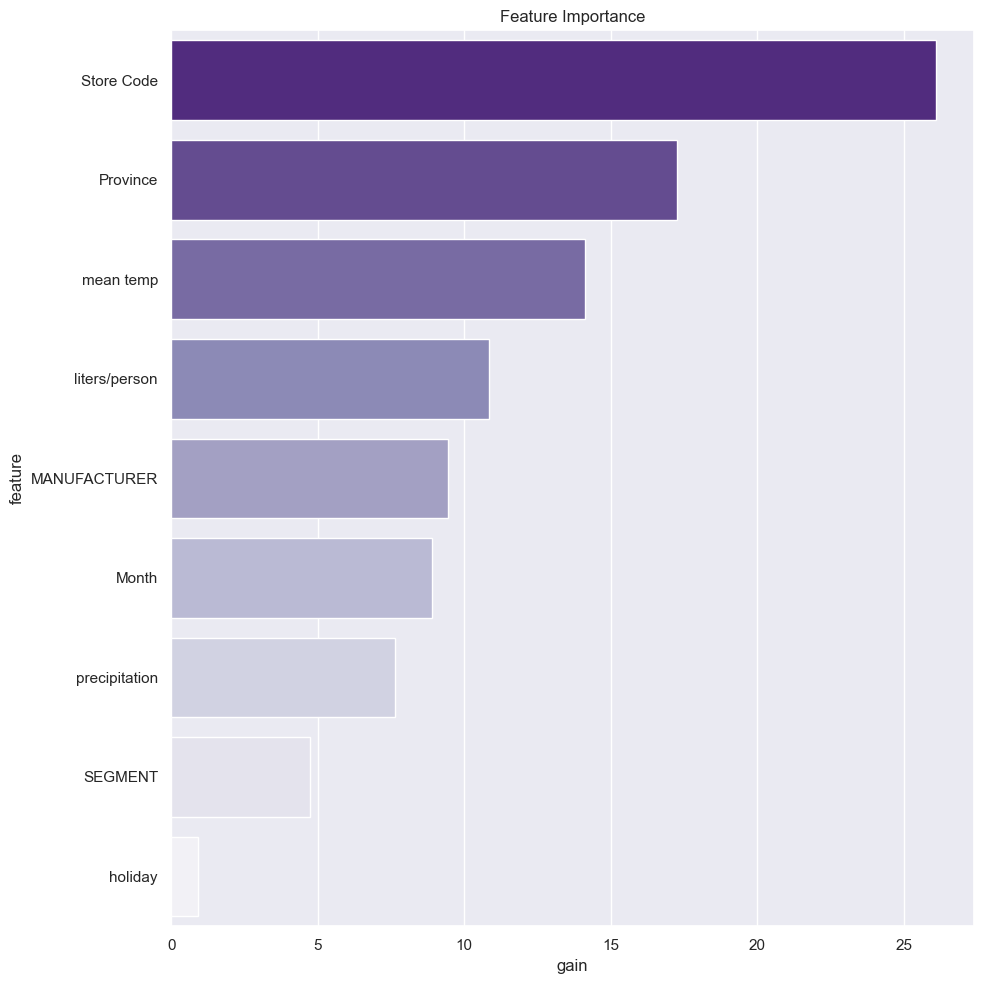

In [134]:
plot_lgb_importances(best_model, plot=True, num=30)

We have been applying hyperparameter tuning for long, but the model is not working better than the previous one. So, we will keep the previous one as the best model for this section.

We have been, at first, using grid search for hyperparameter tuning, but it was taking too long. So, we have decided to use random search instead.

It is pretty interesting to see the differences in feature importance between the two models that we have created for the stores. Special attention to the fact that mean temperature and precipation, which have not been really important in the separated models are now some of the most important features.

# <span style="color: purple">**5. Forecasting applying the best models**</span> <a class="anchor" id="section_5"></a>
## 

Now, we will apply the best models that we have found to predict sales for segments, and for manufacturers. The forecasting will be done for the short term (4 weeks) and for the long term (rest of 2023 and 2024)

The long term prediction has been done in pursuit of the challenge, but it is not really useful, because the data that we have to train the model is not enough to predict sales for the long term. So, we recommend to use the short term prediction.

In [5]:
#First, we will create a dictionary mapping each Week Code to the corresponding Date
week_dict = {1:"03/01/2021", 2: "10/01/2021", 3: "17/01/2021", 4: "24/01/2021", 5: "31/01/2021", 6: "07/02/2021", 7: "14/02/2021", 8: "21/02/2021",
                9: "28/02/2021", 10: "07/03/2021", 11: "14/03/2021", 12: "21/03/2021", 13: "28/03/2021", 14: "04/04/2021", 15: "11/04/2021", 16: "18/04/2021",
                17: "25/04/2021", 18: "02/05/2021", 19: "09/05/2021", 20: "16/05/2021", 21: "23/05/2021", 22: "30/05/2021", 23: "06/06/2021", 24: "13/06/2021",
                25: "20/06/2021", 26: "27/06/2021", 27: "04/07/2021", 28: "11/07/2021", 29: "18/07/2021", 30: "25/07/2021", 31: "01/08/2021", 32: "08/08/2021",
                33: "15/08/2021", 34: "22/08/2021", 35: "29/08/2021", 36: "05/09/2021", 37: "12/09/2021", 38: "19/09/2021", 39: "26/09/2021", 40: "03/10/2021",
                41: "10/10/2021", 42: "17/10/2021", 43: "24/10/2021", 44: "31/10/2021", 45: "07/11/2021", 46: "14/11/2021", 47: "21/11/2021", 48: "28/11/2021",
                49: "05/12/2021", 50: "12/12/2021", 51: "19/12/2021", 52: "26/12/2021", 53: "02/01/2022", 54: "09/01/2022", 55: "16/01/2022", 56: "23/01/2022",
                57: "30/01/2022", 58: "06/02/2022", 59: "13/02/2022", 60: "20/02/2022", 61: "27/02/2022", 62: "06/03/2022", 63: "13/03/2022", 64: "20/03/2022",
                65: "27/03/2022", 66: "03/04/2022", 67: "10/04/2022", 68: "17/04/2022", 69: "24/04/2022", 70: "01/05/2022", 71: "08/05/2022", 72: "15/05/2022",
                73: "22/05/2022", 74: "29/05/2022", 75: "05/06/2022", 76: "12/06/2022", 77: "19/06/2022", 78: "26/06/2022", 79: "03/07/2022", 80: "10/07/2022",
                81: "17/07/2022", 82: "24/07/2022", 83: "31/07/2022", 84: "07/08/2022", 85: "14/08/2022", 86: "21/08/2022", 87: "28/08/2022", 88: "04/09/2022",
                89: "11/09/2022", 90: "18/09/2022", 91: "25/09/2022", 92: "02/10/2022", 93: "09/10/2022", 94: "16/10/2022", 95: "23/10/2022", 96: "30/10/2022",
                97: "06/11/2022", 98: "13/11/2022", 99: "20/11/2022", 100: "27/11/2022", 101: "04/12/2022", 102: "11/12/2022", 103: "18/12/2022", 104: "25/12/2022",
                105: "01/01/2023", 106: "08/01/2023", 107: "15/01/2023", 108: "22/01/2023", 109: "29/01/2023", 110: "05/02/2023", 111: "12/02/2023", 112: "19/02/2023",
                113: "26/02/2023", 114: "05/03/2023", 115: "12/03/2023", 116: "19/03/2023", 117: "26/03/2023", 118: "02/04/2023", 119: "09/04/2023", 120: "16/04/2023",
                121: "23/04/2023", 122: "30/04/2023", 123: "07/05/2023", 124: "14/05/2023", 125: "21/05/2023", 126: "28/05/2023", 127: "04/06/2023", 128: "11/06/2023",
                129: "18/06/2023", 130: "25/06/2023", 131: "02/07/2023", 132: "09/07/2023", 133: "16/07/2023", 134: "23/07/2023", 135: "30/07/2023", 136: "06/08/2023",
                137: "13/08/2023", 138: "20/08/2023", 139: "27/08/2023", 140: "03/09/2023", 141: "10/09/2023", 142: "17/09/2023", 143: "24/09/2023", 144: "01/10/2023",
                145: "08/10/2023", 146: "15/10/2023", 147: "22/10/2023", 148: "29/10/2023", 149: "05/11/2023", 150: "12/11/2023", 151: "19/11/2023", 152: "26/11/2023",
                153: "03/12/2023", 154: "10/12/2023", 155: "17/12/2023", 156: "24/12/2023", 157: "31/12/2023", 158: "07/01/2024", 159: "14/01/2024", 160: "21/01/2024",
                161: "28/01/2024", 162: "04/02/2024", 163: "11/02/2024", 164: "18/02/2024", 165: "25/02/2024", 166: "03/03/2024", 167: "10/03/2024", 168: "17/03/2024",
                169: "24/03/2024", 170: "31/03/2024", 171: "07/04/2024", 172: "14/04/2024", 173: "21/04/2024", 174: "28/04/2024", 175: "05/05/2024", 176: "12/05/2024",
                177: "19/05/2024", 178: "26/05/2024", 179: "02/06/2024", 180: "09/06/2024", 181: "16/06/2024", 182: "23/06/2024", 183: "30/06/2024", 184: "07/07/2024",
                185: "14/07/2024", 186: "21/07/2024", 187: "28/07/2024", 188: "04/08/2024", 189: "11/08/2024", 190: "18/08/2024", 191: "25/08/2024", 192: "01/09/2024",
                193: "08/09/2024", 194: "15/09/2024", 195: "22/09/2024", 196: "29/09/2024", 197: "06/10/2024", 198: "13/10/2024", 199: "20/10/2024", 200: "27/10/2024",
                201: "03/11/2024", 202: "10/11/2024", 203: "17/11/2024", 204: "24/11/2024", 205: "01/12/2024", 206: "08/12/2024", 207: "15/12/2024", 208: "22/12/2024",
                209: "29/12/2024"}

## <span style="color: purple">5.1. Short Term Forecasting for segments</span> <a class="anchor" id="section_5_1"></a>

At this point, we will apply our best ARIMA models to predict sales for each segment for the next 4 weeks.

In [136]:
#Now we will predict for the next 4 weeks for each segment. We will create a new DataFrame to store the predictions for each segment.

#Create a new DataFrame for predictions
predictions_df_segments = pd.DataFrame(columns=["Week Code", "Segment", "Predictions"])

#Iterate over each segment and its best model
for segment, best_model in segment_models_2.items():
    #Get the last available week code for the segment
    last_week_code = segment_data_dict_2[segment]['val'].index[-1]
    
    # Generate predictions for weeks 117, 118, 119, and 120
    future_week_codes = range(last_week_code+1, last_week_code+5)
    predictions = best_model.predict(n_periods=4)
    
    #Add the predicted values to the DataFrame
    segment_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "Segment": segment,
        "Predictions": predictions
    })
    
    #Append segment predictions to the main predictions DataFrame
    predictions_df_segments = predictions_df_segments.append(segment_predictions_df, ignore_index=True)

#Print the predictions for each segment
pd.options.display.float_format = '{:.2f}'.format
print(predictions_df_segments)

   Week Code          Segment  Predictions
0        117         ARTISANS     17115.63
1        118         ARTISANS     17115.63
2        119         ARTISANS     17115.63
3        120         ARTISANS     17115.63
4        117            BLACK     20651.58
5        118            BLACK     21388.08
6        119            BLACK     22220.93
7        120            BLACK     22011.16
8        117          CELIACS     10705.55
9        118          CELIACS     10456.43
10       119          CELIACS     10539.06
11       120          CELIACS     10589.90
12       117            EXTRA    189316.10
13       118            EXTRA    193670.88
14       119            EXTRA    192236.75
15       120            EXTRA    192278.24
16       117        FLAVOURED     91205.10
17       118        FLAVOURED     88701.31
18       119        FLAVOURED     90365.05
19       120        FLAVOURED     91937.20
20       117   IMPORT PREMIUM    575603.79
21       118   IMPORT PREMIUM    499502.50
22       11

## <span style="color: purple">5.2. Long Term Forecasting for segments</span> <a class="anchor" id="section_5_2"></a>

Now, we will apply our best ARIMA models to predict sales for each segment for the rest of 2023 and 2024.

In [137]:
# Create a new DataFrame for predictions
long_predictions_df_segments = pd.DataFrame(columns=["Week Code", "Segment", "Predictions"])

# Iterate over each segment and its best model
for segment, best_model in segment_models_2.items():
    # Get the last available week code for the segment
    last_week_code = segment_data_dict_2[segment]['val'].index[-1]

    # Generate predictions for the next 93 weeks
    future_week_codes = range(last_week_code + 1, last_week_code + 94)
    predictions = best_model.predict(n_periods=93)

    # Add the predicted values to the DataFrame
    segment_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "Segment": segment,
        "Predictions": predictions
    })

    # Append segment predictions to the long predictions DataFrame
    long_predictions_df_segments = long_predictions_df_segments.append(segment_predictions_df, ignore_index=True)

# Print the predictions for each segment
pd.options.display.float_format = '{:.2f}'.format
print(long_predictions_df_segments)

    Week Code       Segment  Predictions
0         117      ARTISANS     17115.63
1         118      ARTISANS     17115.63
2         119      ARTISANS     17115.63
3         120      ARTISANS     17115.63
4         121      ARTISANS     17115.63
..        ...           ...          ...
925       205  ZERO ALCOHOL    126251.40
926       206  ZERO ALCOHOL    126499.21
927       207  ZERO ALCOHOL    126747.01
928       208  ZERO ALCOHOL    126994.81
929       209  ZERO ALCOHOL    127242.61

[930 rows x 3 columns]


We have got our predictions for the short and the long term. What we are going to do now is to **create a df containing all segments sales per week (including historical, short term and long term predictions)**. We will export this df to a csv file to further work on it in future iterations.

In [138]:
#First, we get index as column called Week Code for ts_simple_autoarima_segment (containing historical data)
ts_simple_autoarima_segment.reset_index(level=0, inplace=True)


In [139]:
#We transform Week Code to object and sales to float, to do a proper append in the next step
ts_simple_autoarima_segment['Week Code'] = ts_simple_autoarima_segment['Week Code'].astype(str)
ts_simple_autoarima_segment['Sales in value (€)'] = ts_simple_autoarima_segment['Sales in value (€)'].astype(float)

In [140]:
#Add a new column to ts_simple_autoarima_segment called Source, and fill all the values with 'Historical data', to easily identify the source of the data
ts_simple_autoarima_segment['Source'] = 'Historical data'

In [141]:
#Add a new column to long_predictions_df_segments called Source, to easily identify the source of the data
long_predictions_df_segments['Source'] = np.where(long_predictions_df_segments['Week Code'].isin([117, 118, 119, 120]), 'Short Term Predictions', 'Long Term Predictions')

In [142]:
#We rename column predictions to Sales in value (€) and Segment to SEGMENT , to do a proper append in the next step
long_predictions_df_segments.rename(columns={'Predictions': 'Sales in value (€)'}, inplace=True)
long_predictions_df_segments.rename(columns={'Segment': 'SEGMENT'}, inplace=True)

In [143]:
#Create a new df called all_predictions_for_segments and concatenate ts_simple_autoarima_segment and long_predictions_df_segments
all_predictions_for_segments = pd.concat([ts_simple_autoarima_segment, long_predictions_df_segments], ignore_index=True)

In [144]:
#convert Week Code to int
all_predictions_for_segments['Week Code'] = all_predictions_for_segments['Week Code'].astype(int)

In [145]:
#Add a new column called Week Date to all_predictions_for_segments, using the dictionary week_dict
all_predictions_for_segments['Week Date'] = all_predictions_for_segments['Week Code'].map(week_dict)

In [146]:
all_predictions_for_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           2090 non-null   int32  
 1   SEGMENT             2090 non-null   object 
 2   Sales in value (€)  2090 non-null   float64
 3   Source              2090 non-null   object 
 4   Week Date           2090 non-null   object 
dtypes: float64(1), int32(1), object(3)
memory usage: 73.6+ KB


In [147]:
all_predictions_for_segments.head()

Week Code    SEGMENT  Sales in value (€)           Source   Week Date
0          1   ARTISANS             6063.14  Historical data  03/01/2021
1          1      BLACK            20293.01  Historical data  03/01/2021
2          1    CELIACS             6735.88  Historical data  03/01/2021
3          1      EXTRA           132903.83  Historical data  03/01/2021
4          1  FLAVOURED            77241.48  Historical data  03/01/2021

In [148]:
# Uncomment as a checkpoint if needed
# #Now that we have our df ready, we will export it to a csv file
# all_predictions_for_segments.to_csv('value_predictions_for_segments.csv', index=False)

## <span style="color: purple">5.3. Short Term Forecasting for manufacturers</span> <a class="anchor" id="section_5_3"></a>

At this point, we will apply our best ARIMA models to predict sales for each manufacturer for the next 4 weeks.

In [149]:
#Now we will predict for the next 4 weeks for each manufacturer. We will create a new DataFrame to store the predictions for each manufacturer.

#Create a new DataFrame for predictions
predictions_df_manufacturer = pd.DataFrame(columns=["Week Code", "manufacturer", "Predictions"])

#Iterate over each manufacturer and its best model
for manufacturer, best_model in manufacturer_models_2.items():
    #Get the last available week code for the manufacturer
    last_week_code = manufacturer_data_dict_2[manufacturer]['val'].index[-1]
    
    # Generate predictions for weeks 117, 118, 119, and 120
    future_week_codes = range(last_week_code+1, last_week_code+5)
    predictions = best_model.predict(n_periods=4)
    
    #Add the predicted values to the DataFrame
    manufacturer_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "manufacturer": manufacturer,
        "Predictions": predictions
    })
    
    #Append manufacturer predictions to the main predictions DataFrame
    predictions_df_manufacturer = predictions_df_manufacturer.append(manufacturer_predictions_df, ignore_index=True)

#Print the predictions for each manufacturer
pd.options.display.float_format = '{:.2f}'.format
print(predictions_df_manufacturer)

   Week Code         manufacturer  Predictions
0        117       MANUFACTURER 1    224578.38
1        118       MANUFACTURER 1    233022.62
2        119       MANUFACTURER 1    239326.80
3        120       MANUFACTURER 1    244033.28
4        117       MANUFACTURER 2    553270.85
5        118       MANUFACTURER 2    551796.79
6        119       MANUFACTURER 2    572884.48
7        120       MANUFACTURER 2    600376.86
8        117       MANUFACTURER 3    930767.75
9        118       MANUFACTURER 3    929864.92
10       119       MANUFACTURER 3    938366.31
11       120       MANUFACTURER 3    930496.05
12       117       MANUFACTURER 4    178915.94
13       118       MANUFACTURER 4    161737.33
14       119       MANUFACTURER 4    160271.58
15       120       MANUFACTURER 4    161315.84
16       117       MANUFACTURER 5     61131.85
17       118       MANUFACTURER 5     58740.62
18       119       MANUFACTURER 5     62796.12
19       120       MANUFACTURER 5     65534.62
20       117 

## <span style="color: purple">5.4. Long Term Forecasting for manufacturers</span> <a class="anchor" id="section_5_4"></a>

Now, we will apply our best ARIMA models to predict sales for each manufacturer for the rest of 2023 and 2024.

In [150]:
# Create a new DataFrame for predictions
long_predictions_df_manufacturer = pd.DataFrame(columns=["Week Code", "manufacturer", "Predictions"])

# Iterate over each manufacturer and its best model
for manufacturer, best_model in manufacturer_models_2.items():
    # Get the last available week code for the manufacturer
    last_week_code = manufacturer_data_dict_2[manufacturer]['val'].index[-1]

    # Generate predictions for the next 93 weeks
    future_week_codes = range(last_week_code + 1, last_week_code + 94)
    predictions = best_model.predict(n_periods=93)

    # Add the predicted values to the DataFrame
    manufacturer_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "manufacturer": manufacturer,
        "Predictions": predictions
    })

    # Append manufacturer predictions to the long predictions DataFrame
    long_predictions_df_manufacturer = long_predictions_df_manufacturer.append(manufacturer_predictions_df, ignore_index=True)

# Print the predictions for each manufacturer
pd.options.display.float_format = '{:.2f}'.format
print(long_predictions_df_manufacturer)

    Week Code         manufacturer  Predictions
0         117       MANUFACTURER 1    224578.38
1         118       MANUFACTURER 1    233022.62
2         119       MANUFACTURER 1    239326.80
3         120       MANUFACTURER 1    244033.28
4         121       MANUFACTURER 1    247546.98
..        ...                  ...          ...
646       205  OTHER MANUFACTURERS     99892.17
647       206  OTHER MANUFACTURERS     99558.00
648       207  OTHER MANUFACTURERS     99223.84
649       208  OTHER MANUFACTURERS     98889.67
650       209  OTHER MANUFACTURERS     98555.50

[651 rows x 3 columns]


We have got our predictions for the short and the long term. What we are going to do now is to **create a df containing all manufacturers sales per week (including historical, short term and long term predictions)**. We will export this df to a csv file to further work on it in future iterations.

In [151]:
#First, we get index as column called Week Code for ts_simple_autoarima_manufacturer (containing historical data)
ts_simple_autoarima_manufacturer.reset_index(level=0, inplace=True)


In [152]:
#We transform Week Code to object and sales to float, to do a proper append in the next step
ts_simple_autoarima_manufacturer['Week Code'] = ts_simple_autoarima_manufacturer['Week Code'].astype(str)
ts_simple_autoarima_manufacturer['Sales in value (€)'] = ts_simple_autoarima_manufacturer['Sales in value (€)'].astype(float)

In [153]:
#Add a new column to ts_simple_autoarima_manufacturer called Source, and fill all the values with 'Historical data', to easily identify the source of the data
ts_simple_autoarima_manufacturer['Source'] = 'Historical data'

In [154]:
#Add a new column to long_predictions_df_manufacturer called Source, to easily identify the source of the data
long_predictions_df_manufacturer['Source'] = np.where(long_predictions_df_manufacturer['Week Code'].isin([117, 118, 119, 120]), 'Short Term Predictions', 'Long Term Predictions')

In [155]:
#We rename column predictions to Sales in value (€) and manufacturer to MANUFACTURER , to do a proper append in the next step
long_predictions_df_manufacturer.rename(columns={'Predictions': 'Sales in value (€)'}, inplace=True)
long_predictions_df_manufacturer.rename(columns={'manufacturer': 'MANUFACTURER'}, inplace=True)

In [156]:
#Create a new df called all_predictions_for_manufacturer and concatenate ts_simple_autoarima_manufacturer and long_predictions_df_manufacturer
all_predictions_for_manufacturers = pd.concat([ts_simple_autoarima_manufacturer, long_predictions_df_manufacturer], ignore_index=True)

In [157]:
#convert Week Code to int
all_predictions_for_manufacturers['Week Code'] = all_predictions_for_manufacturers['Week Code'].astype(int)

In [158]:
#Add a new column called Week Date to all_predictions_for_manufacturers, using the dictionary week_dict
all_predictions_for_manufacturers['Week Date'] = all_predictions_for_manufacturers['Week Code'].map(week_dict)

In [159]:
all_predictions_for_manufacturers.head()

Week Code    MANUFACTURER  Sales in value (€)           Source   Week Date
0          1  MANUFACTURER 1           195122.16  Historical data  03/01/2021
1          1  MANUFACTURER 2           529572.53  Historical data  03/01/2021
2          1  MANUFACTURER 3           768081.25  Historical data  03/01/2021
3          1  MANUFACTURER 4           125312.57  Historical data  03/01/2021
4          1  MANUFACTURER 5            46182.27  Historical data  03/01/2021

In [160]:
all_predictions_for_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           1463 non-null   int32  
 1   MANUFACTURER        1463 non-null   object 
 2   Sales in value (€)  1463 non-null   float64
 3   Source              1463 non-null   object 
 4   Week Date           1463 non-null   object 
dtypes: float64(1), int32(1), object(3)
memory usage: 51.6+ KB


In [161]:
# Uncomment as a checkpoint if needed
# #Now that we have our df ready, we will export it to a csv file
# all_predictions_for_manufacturers.to_csv('value_predictions_for_manufacturers.csv', index=False)

# <span style="color: purple">**6. Conclusions on the work performed**</span> <a class="anchor" id="section_6"></a>

For the conclussions, they are more related at this point on technical aspects, so we advice to look at the notebook 4.1. to see them, as they are mainly the same with the exception of a good LightGBM model we have found for segments using value.

# <span style="color: purple">**7. Some "big" numbers on the forecasting**</span> <a class="anchor" id="section_7"></a>


In [162]:
# Uncomment as a checkpoint if needed
# all_predictions_for_manufacturers = pd.read_csv('value_predictions_for_manufacturers.csv')
# all_predictions_for_segments = pd.read_csv('value_predictions_for_segments.csv')

## <span style="color: purple">7.1. The 2023-2024 numbers for segments</span> <a class="anchor" id="section_7_1"></a>

In [163]:
#From all_predictions_for_segments, add a new column containing the year, which now is the last part of the Week Date column
all_predictions_for_segments['Year'] = all_predictions_for_segments['Week Date'].str[-4:]


In [164]:
#check unique values for Year
all_predictions_for_segments['Year'].unique()

array(['2021', '2022', '2023', '2024'], dtype=object)

In [165]:
all_predictions_for_segments.head()

Week Code    SEGMENT  Sales in value (€)           Source   Week Date  Year
0          1   ARTISANS             6063.14  Historical data  03/01/2021  2021
1          1      BLACK            20293.01  Historical data  03/01/2021  2021
2          1    CELIACS             6735.88  Historical data  03/01/2021  2021
3          1      EXTRA           132903.83  Historical data  03/01/2021  2021
4          1  FLAVOURED            77241.48  Historical data  03/01/2021  2021

In [166]:
#drop week code, source and week date columns
all_predictions_for_segments.drop(['Week Code', 'Source', 'Week Date'], axis=1, inplace=True)

In [167]:
#Sum all the sales in volume for each segment and year
all_predictions_for_segments = all_predictions_for_segments.groupby(['SEGMENT', 'Year']).sum()

In [168]:
#Now, we stablish year rows as columns
all_predictions_for_segments = all_predictions_for_segments.unstack(level=1)

In [169]:
#Get 2023 and 2024 columns in float with 2 decimals
# Set the desired formatting function for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [170]:
all_predictions_for_segments

Sales in value (€)                                    
Year                          2021        2022        2023        2024
SEGMENT                                                               
ARTISANS                 598692.68   775805.97   893169.04   890012.76
BLACK                   1279072.17  1232037.75  1190097.36  1297233.42
CELIACS                  565466.07   595700.24   560497.11   558377.85
EXTRA                   9316081.31 10986207.54 10068112.48 10001268.84
FLAVOURED               6817103.20  7317492.44  5126979.99  5679651.82
IMPORT PREMIUM         22426200.04 24496223.00 18919867.41 13909364.01
IMPORT SPECIAL          5601173.50  5908355.09  5077060.52  5016286.06
NATIONAL               89782733.27 96333774.45 86145344.14 90034520.93
WITHOUT ALCOHOL         3963119.28  4100241.34  3056674.23  2995880.39
ZERO ALCOHOL            5107131.60  5998961.35  5686334.08  6288030.35

## <span style="color: purple">7.2. The 2023-2024 numbers for manufacturers</span> <a class="anchor" id="section_7_2"></a>

In [171]:
#From all_predictions_for_manufacturers, add a new column containing the year, which now is the last part of the Week Date column
all_predictions_for_manufacturers['Year'] = all_predictions_for_manufacturers['Week Date'].str[-4:]


In [172]:
#check unique values for Year
all_predictions_for_manufacturers['Year'].unique()

array(['2021', '2022', '2023', '2024'], dtype=object)

In [173]:
all_predictions_for_manufacturers.head()

Week Code    MANUFACTURER  Sales in value (€)           Source   Week Date  \
0          1  MANUFACTURER 1           195122.16  Historical data  03/01/2021   
1          1  MANUFACTURER 2           529572.53  Historical data  03/01/2021   
2          1  MANUFACTURER 3           768081.25  Historical data  03/01/2021   
3          1  MANUFACTURER 4           125312.57  Historical data  03/01/2021   
4          1  MANUFACTURER 5            46182.27  Historical data  03/01/2021   

   Year  
0  2021  
1  2021  
2  2021  
3  2021  
4  2021

In [174]:
#drop week code, source and week date columns
all_predictions_for_manufacturers.drop(['Week Code', 'Source', 'Week Date'], axis=1, inplace=True)

In [175]:
#Sum all the sales in volume for each manufacturer and year
all_predictions_for_manufacturers = all_predictions_for_manufacturers.groupby(['MANUFACTURER', 'Year']).sum()

In [176]:
#Now, we stablish year rows as columns
all_predictions_for_manufacturers = all_predictions_for_manufacturers.unstack(level=1)

In [177]:
all_predictions_for_manufacturers

Sales in value (€)                                    
Year                              2021        2022        2023        2024
MANUFACTURER                                                              
MANUFACTURER 1             13584318.20 13865710.58 13117010.42 13410676.12
MANUFACTURER 2             39629710.74 43469593.15 31279958.22 31198535.17
MANUFACTURER 3             54662462.69 61299672.19 49502896.71 47359312.36
MANUFACTURER 4              7046277.01  8227605.40  8004178.68  7667013.42
MANUFACTURER 5              3589725.55  3998997.06  3611291.48  4257338.48
MANUFACTURER 6             20006019.67 19555442.27 15370353.02  9503487.01
OTHER MANUFACTURERS         6938259.26  7327778.52  6542507.65  5567992.23

## <span style="color: purple">7.3. The 2023-2024 numbers for beer</span> <a class="anchor" id="section_7_3"></a>

We have calculated the total beer that will be sell by segment and also, the total beer that will be sell by manufacturer. If all the segments are represented, and all the manufacturers also, the data would be perfectly complete. If that is the case, the result of adding up the sales of each segment should be the same as the result of adding up the sales of each manufacturer.

Despite that, as we have said, we are forecasting to the long term, and we have only 116 weeks of data. So, the most possible outcome is that the result of adding up the sales of each segment is not the same as the result of adding up the sales of each manufacturer due to the errors of the forecasting.

In [178]:
#We are going to start by calculating the total sales of beer based on our segments predictions

total_sales = all_predictions_for_segments.sum(axis=0)
all_predictions_for_segments.loc['Total Sales'] = total_sales


all_predictions_for_segments

Sales in value (€)                                       
Year                          2021         2022         2023         2024
SEGMENT                                                                  
ARTISANS                 598692.68    775805.97    893169.04    890012.76
BLACK                   1279072.17   1232037.75   1190097.36   1297233.42
CELIACS                  565466.07    595700.24    560497.11    558377.85
EXTRA                   9316081.31  10986207.54  10068112.48  10001268.84
FLAVOURED               6817103.20   7317492.44   5126979.99   5679651.82
IMPORT PREMIUM         22426200.04  24496223.00  18919867.41  13909364.01
IMPORT SPECIAL          5601173.50   5908355.09   5077060.52   5016286.06
NATIONAL               89782733.27  96333774.45  86145344.14  90034520.93
WITHOUT ALCOHOL         3963119.28   4100241.34   3056674.23   2995880.39
ZERO ALCOHOL            5107131.60   5998961.35   5686334.08   6288030.35
Total Sales           145456773.12 157744799.17 136724136.36 136670626.43

In [179]:
#Now that we have the total sales for each year for each segment, we are going to calculate the evolution in percentual terms


variation_2022 = (all_predictions_for_segments[('Sales in value (€)', '2022')] - all_predictions_for_segments[('Sales in value (€)', '2021')]) / all_predictions_for_segments[('Sales in value (€)', '2021')] * 100
variation_2023 = (all_predictions_for_segments[('Sales in value (€)', '2023')] - all_predictions_for_segments[('Sales in value (€)', '2022')]) / all_predictions_for_segments[('Sales in value (€)', '2022')] * 100
variation_2024 = (all_predictions_for_segments[('Sales in value (€)', '2024')] - all_predictions_for_segments[('Sales in value (€)', '2023')]) / all_predictions_for_segments[('Sales in value (€)', '2023')] * 100

#Create a new MultiIndex for the updated columns
new_columns = pd.MultiIndex.from_tuples([
    ('Sales in value (€)', '2021'),
    ('Sales in value (€)', '2022'),
    ('Sales in value (€)', '2023'),
    ('Sales in value (€)', '2024'),
    ('Percentual Variation', '2022'),
    ('Percentual Variation', '2023'),
    ('Percentual Variation', '2024')
], names=[None, 'Year'])

#Create a new DataFrame with the updated columns
all_value_predictions_for_segments = pd.DataFrame(index=all_predictions_for_segments.index, columns=new_columns)

#Copy the existing data to the new DataFrame
all_value_predictions_for_segments[('Sales in value (€)', '2021')] = all_predictions_for_segments[('Sales in value (€)', '2021')]
all_value_predictions_for_segments[('Sales in value (€)', '2022')] = all_predictions_for_segments[('Sales in value (€)', '2022')]
all_value_predictions_for_segments[('Sales in value (€)', '2023')] = all_predictions_for_segments[('Sales in value (€)', '2023')]
all_value_predictions_for_segments[('Sales in value (€)', '2024')] = all_predictions_for_segments[('Sales in value (€)', '2024')]

#Add the percentual variation values to the new DataFrame
all_value_predictions_for_segments[('Percentual Variation', '2022')] = variation_2022
all_value_predictions_for_segments[('Percentual Variation', '2023')] = variation_2023
all_value_predictions_for_segments[('Percentual Variation', '2024')] = variation_2024

In [180]:
#change percentual variation columns to percentage
all_value_predictions_for_segments[('Percentual Variation', '2022')] = all_value_predictions_for_segments[('Percentual Variation', '2022')].apply(lambda x: "{:.2f}%".format(x))
all_value_predictions_for_segments[('Percentual Variation', '2023')] = all_value_predictions_for_segments[('Percentual Variation', '2023')].apply(lambda x: "{:.2f}%".format(x))
all_value_predictions_for_segments[('Percentual Variation', '2024')] = all_value_predictions_for_segments[('Percentual Variation', '2024')].apply(lambda x: "{:.2f}%".format(x))

In [181]:
all_value_predictions_for_segments

Sales in value (€)                                         \
Year                          2021         2022         2023         2024   
SEGMENT                                                                     
ARTISANS                 598692.68    775805.97    893169.04    890012.76   
BLACK                   1279072.17   1232037.75   1190097.36   1297233.42   
CELIACS                  565466.07    595700.24    560497.11    558377.85   
EXTRA                   9316081.31  10986207.54  10068112.48  10001268.84   
FLAVOURED               6817103.20   7317492.44   5126979.99   5679651.82   
IMPORT PREMIUM         22426200.04  24496223.00  18919867.41  13909364.01   
IMPORT SPECIAL          5601173.50   5908355.09   5077060.52   5016286.06   
NATIONAL               89782733.27  96333774.45  86145344.14  90034520.93   
WITHOUT ALCOHOL         3963119.28   4100241.34   3056674.23   2995880.39   
ZERO ALCOHOL            5107131.60   5998961.35   5686334.08   6288030.35   
Total Sales           145456773.12 157744799.17 136724136.36 136670626.43   

                Percentual Variation                    
Year                            2022     2023     2024  
SEGMENT                                                 
ARTISANS                      29.58%   15.13%   -0.35%  
BLACK                         -3.68%   -3.40%    9.00%  
CELIACS                        5.35%   -5.91%   -0.38%  
EXTRA                         17.93%   -8.36%   -0.66%  
FLAVOURED                      7.34%  -29.94%   10.78%  
IMPORT PREMIUM                 9.23%  -22.76%  -26.48%  
IMPORT SPECIAL                 5.48%  -14.07%   -1.20%  
NATIONAL                       7.30%  -10.58%    4.51%  
WITHOUT ALCOHOL                3.46%  -25.45%   -1.99%  
ZERO ALCOHOL                  17.46%   -5.21%   10.58%  
Total Sales                    8.45%  -13.33%   -0.04%

In [182]:
all_value_predictions_for_segments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, ARTISANS to Total Sales
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (Sales in value (€), 2021)    11 non-null     float64
 1   (Sales in value (€), 2022)    11 non-null     float64
 2   (Sales in value (€), 2023)    11 non-null     float64
 3   (Sales in value (€), 2024)    11 non-null     float64
 4   (Percentual Variation, 2022)  11 non-null     object 
 5   (Percentual Variation, 2023)  11 non-null     object 
 6   (Percentual Variation, 2024)  11 non-null     object 
dtypes: float64(4), object(3)
memory usage: 704.0+ bytes


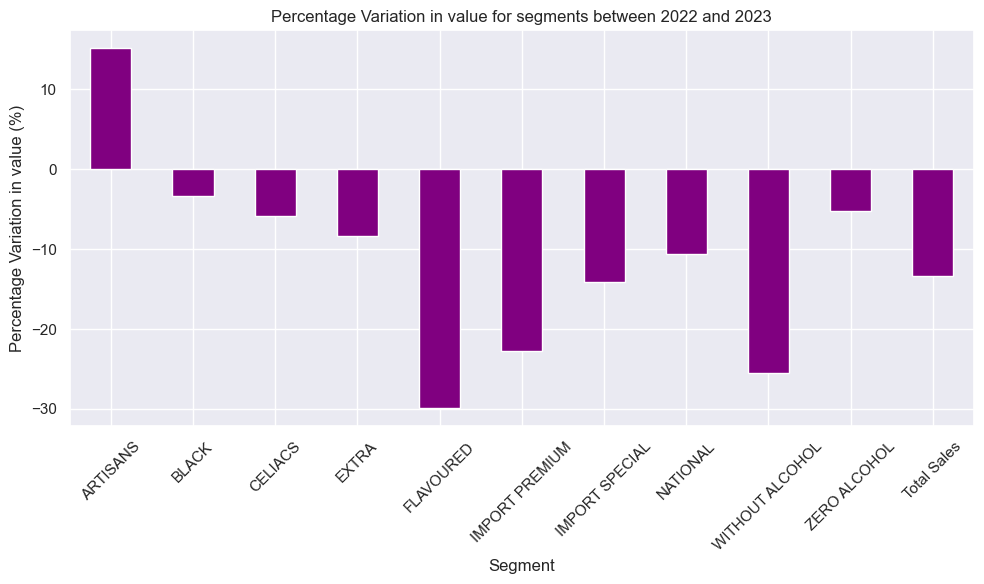

In [184]:
#Get the percentage variation between 2022 and 2023
percent_change = all_value_predictions_for_segments[('Percentual Variation', '2023')].str.rstrip('%').astype('float')

plt.figure(figsize=(10, 6))
percent_change.plot(kind='bar', color='purple')
plt.title('Percentage Variation in value for segments between 2022 and 2023')
plt.xlabel('Segment')
plt.ylabel('Percentage Variation in value (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [185]:
#Now We are going to start by calculating the total sales of beer based on our manufacturers predictions

total_sales_manufacturer = all_predictions_for_manufacturers.sum(axis=0)
all_predictions_for_manufacturers.loc['Total Sales'] = total_sales_manufacturer


all_predictions_for_manufacturers

Sales in value (€)                                       
Year                              2021         2022         2023         2024
MANUFACTURER                                                                 
MANUFACTURER 1             13584318.20  13865710.58  13117010.42  13410676.12
MANUFACTURER 2             39629710.74  43469593.15  31279958.22  31198535.17
MANUFACTURER 3             54662462.69  61299672.19  49502896.71  47359312.36
MANUFACTURER 4              7046277.01   8227605.40   8004178.68   7667013.42
MANUFACTURER 5              3589725.55   3998997.06   3611291.48   4257338.48
MANUFACTURER 6             20006019.67  19555442.27  15370353.02   9503487.01
OTHER MANUFACTURERS         6938259.26   7327778.52   6542507.65   5567992.23
Total Sales               145456773.12 157744799.17 127428196.17 118964354.79

In [186]:
#Now that we have the total sales for each year for each manufacturer, we are going to calculate the evolution in percentual terms


variation_2022 = (all_predictions_for_manufacturers[('Sales in value (€)', '2022')] - all_predictions_for_manufacturers[('Sales in value (€)', '2021')]) / all_predictions_for_manufacturers[('Sales in value (€)', '2021')] * 100
variation_2023 = (all_predictions_for_manufacturers[('Sales in value (€)', '2023')] - all_predictions_for_manufacturers[('Sales in value (€)', '2022')]) / all_predictions_for_manufacturers[('Sales in value (€)', '2022')] * 100
variation_2024 = (all_predictions_for_manufacturers[('Sales in value (€)', '2024')] - all_predictions_for_manufacturers[('Sales in value (€)', '2023')]) / all_predictions_for_manufacturers[('Sales in value (€)', '2023')] * 100

#Create a new MultiIndex for the updated columns
new_columns = pd.MultiIndex.from_tuples([
    ('Sales in value (€)', '2021'),
    ('Sales in value (€)', '2022'),
    ('Sales in value (€)', '2023'),
    ('Sales in value (€)', '2024'),
    ('Percentual Variation', '2022'),
    ('Percentual Variation', '2023'),
    ('Percentual Variation', '2024')
], names=[None, 'Year'])

#Create a new DataFrame with the updated columns
all_value_predictions_for_manufacturers = pd.DataFrame(index=all_predictions_for_manufacturers.index, columns=new_columns)

#Copy the existing data to the new DataFrame
all_value_predictions_for_manufacturers[('Sales in value (€)', '2021')] = all_predictions_for_manufacturers[('Sales in value (€)', '2021')]
all_value_predictions_for_manufacturers[('Sales in value (€)', '2022')] = all_predictions_for_manufacturers[('Sales in value (€)', '2022')]
all_value_predictions_for_manufacturers[('Sales in value (€)', '2023')] = all_predictions_for_manufacturers[('Sales in value (€)', '2023')]
all_value_predictions_for_manufacturers[('Sales in value (€)', '2024')] = all_predictions_for_manufacturers[('Sales in value (€)', '2024')]

#Add the percentual variation values to the new DataFrame
all_value_predictions_for_manufacturers[('Percentual Variation', '2022')] = variation_2022
all_value_predictions_for_manufacturers[('Percentual Variation', '2023')] = variation_2023
all_value_predictions_for_manufacturers[('Percentual Variation', '2024')] = variation_2024

In [187]:
#change percentual variation columns to percentage
all_value_predictions_for_manufacturers[('Percentual Variation', '2022')] = all_value_predictions_for_manufacturers[('Percentual Variation', '2022')].apply(lambda x: "{:.2f}%".format(x))
all_value_predictions_for_manufacturers[('Percentual Variation', '2023')] = all_value_predictions_for_manufacturers[('Percentual Variation', '2023')].apply(lambda x: "{:.2f}%".format(x))
all_value_predictions_for_manufacturers[('Percentual Variation', '2024')] = all_value_predictions_for_manufacturers[('Percentual Variation', '2024')].apply(lambda x: "{:.2f}%".format(x))

In [188]:
all_value_predictions_for_manufacturers

Sales in value (€)                                         \
Year                              2021         2022         2023         2024   
MANUFACTURER                                                                    
MANUFACTURER 1             13584318.20  13865710.58  13117010.42  13410676.12   
MANUFACTURER 2             39629710.74  43469593.15  31279958.22  31198535.17   
MANUFACTURER 3             54662462.69  61299672.19  49502896.71  47359312.36   
MANUFACTURER 4              7046277.01   8227605.40   8004178.68   7667013.42   
MANUFACTURER 5              3589725.55   3998997.06   3611291.48   4257338.48   
MANUFACTURER 6             20006019.67  19555442.27  15370353.02   9503487.01   
OTHER MANUFACTURERS         6938259.26   7327778.52   6542507.65   5567992.23   
Total Sales               145456773.12 157744799.17 127428196.17 118964354.79   

                    Percentual Variation                    
Year                                2022     2023     2024  
MANUFACTURER                                                
MANUFACTURER 1                     2.07%   -5.40%    2.24%  
MANUFACTURER 2                     9.69%  -28.04%   -0.26%  
MANUFACTURER 3                    12.14%  -19.24%   -4.33%  
MANUFACTURER 4                    16.77%   -2.72%   -4.21%  
MANUFACTURER 5                    11.40%   -9.70%   17.89%  
MANUFACTURER 6                    -2.25%  -21.40%  -38.17%  
OTHER MANUFACTURERS                5.61%  -10.72%  -14.90%  
Total Sales                        8.45%  -19.22%   -6.64%

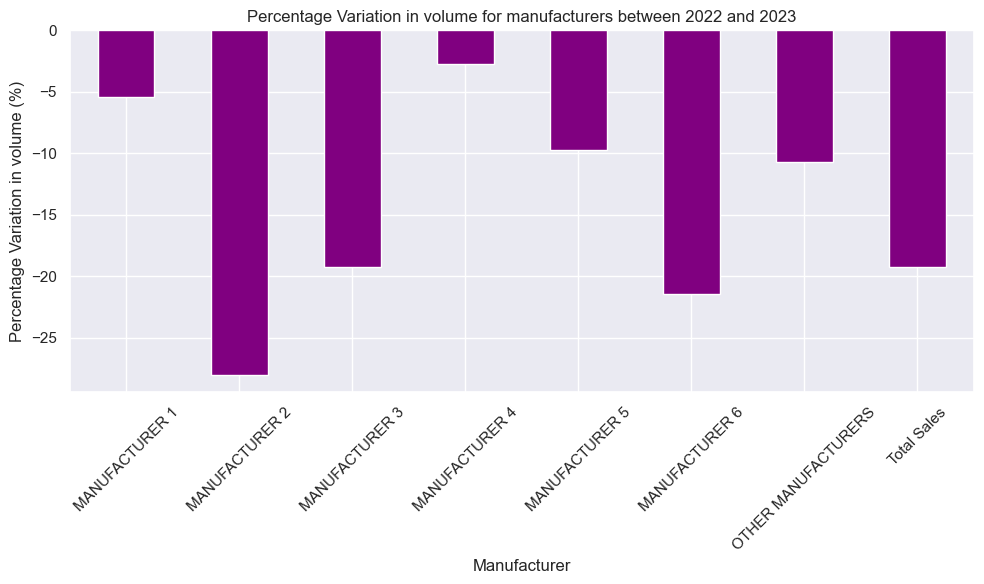

In [189]:
#Get the percentage variation between 2022 and 2023
percent_change = all_value_predictions_for_manufacturers[('Percentual Variation', '2023')].str.rstrip('%').astype('float')

plt.figure(figsize=(10, 6))
percent_change.plot(kind='bar', color='purple')
plt.title('Percentage Variation in volume for manufacturers between 2022 and 2023')
plt.xlabel('Manufacturer')
plt.ylabel('Percentage Variation in volume (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [190]:
# Uncomment as a checkpoint if needed
# #Store all_value_predictions_for_manufacturers and all_value_predictions_for_segments in a csv file
# all_value_predictions_for_manufacturers.to_csv('all_value_predictions_for_manufacturers.csv')
# all_value_predictions_for_segments.to_csv('all_value_predictions_for_segments.csv')

# <span style="color: purple">**8. A final combined approach**</span> <a class="anchor" id="section_8"></a>

We have seen that there are some errors in between the total predicted sum for manufacturers and for segments. To deal with this issue, we will provide a new 'combined' forecast using the autoarima with hyperparameter tuning approach

In [6]:
#We get a copy of the df
ts_simple_autoarima = ts_simple_data.copy()

In [7]:
#We do the preparations for having a dataset suitable to be used by the autoarima function
ts_simple_autoarima = ts_simple_autoarima.set_index('Week Code')
ts_simple_autoarima = ts_simple_autoarima.drop(['Month', 'Year', 'Season', 'Quarter'], axis=1)

ts_simple_autoarima_combinations = ts_simple_autoarima.groupby(['Week Code', 'SEGMENT', 'MANUFACTURER'])['Sales in value (€)'].sum().reset_index()

In [8]:
ts_simple_autoarima_combinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           6702 non-null   int64  
 1   SEGMENT             6702 non-null   object 
 2   MANUFACTURER        6702 non-null   object 
 3   Sales in value (€)  6702 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 209.6+ KB


In [9]:
#concatenate the segment and manufacturer columns
ts_simple_autoarima_combinations['combinations'] = ts_simple_autoarima_combinations['SEGMENT'] + '_' + ts_simple_autoarima_combinations['MANUFACTURER']

In [10]:
ts_simple_autoarima_combinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           6702 non-null   int64  
 1   SEGMENT             6702 non-null   object 
 2   MANUFACTURER        6702 non-null   object 
 3   Sales in value (€)  6702 non-null   float64
 4   combinations        6702 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 261.9+ KB


In [11]:
ts_simple_autoarima_combinations.head()

Week Code   SEGMENT         MANUFACTURER  Sales in value (€)  \
0          1  ARTISANS       MANUFACTURER 5              766.69   
1          1  ARTISANS  OTHER MANUFACTURERS             5296.45   
2          1     BLACK       MANUFACTURER 1             1359.37   
3          1     BLACK       MANUFACTURER 2             6159.95   
4          1     BLACK       MANUFACTURER 3             1659.79   

                   combinations  
0       ARTISANS_MANUFACTURER 5  
1  ARTISANS_OTHER MANUFACTURERS  
2          BLACK_MANUFACTURER 1  
3          BLACK_MANUFACTURER 2  
4          BLACK_MANUFACTURER 3

In [12]:
ts_simple_autoarima_combinations = ts_simple_autoarima_combinations.drop(['SEGMENT', 'MANUFACTURER'], axis=1)

In [15]:
#At this point, we are just checking for missing weeks in the dataset

#Create a reference DataFrame with all possible combinations and weeks
combinations = ts_simple_autoarima_combinations['combinations'].unique()
weeks = range(1, 117)  # Weeks from 1 to 116
reference_df = pd.MultiIndex.from_product([combinations, weeks], names=['combinations', 'Week Code']).to_frame(index=False)

#Merge the reference DataFrame with the original DataFrame
merged_df = pd.merge(reference_df, ts_simple_autoarima_combinations, on=['combinations', 'Week Code'], how='left')

#Check for missing values in the merged DataFrame
missing_data = merged_df[merged_df['Sales in value (€)'].isnull()]
missing_combinations = missing_data['combinations'].unique()
missing_weeks = missing_data['Week Code'].unique()

print(f"Missing combinations: {missing_combinations}")
print(f"Missing weeks: {missing_weeks}")

Missing combinations: ['ARTISANS_MANUFACTURER 3' 'CELIACS_MANUFACTURER 6'
 'ARTISANS_MANUFACTURER 4' 'ARTISANS_MANUFACTURER 1']
Missing weeks: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  24  36  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88 114 115
 116  89  90  91  92  93  94  95  96  97  98]


In [17]:
#Now that we have seen, and confirmed, that there are missing weeks in the dataset, we will fill them with 0

#Create a reference DataFrame with all possible combinations and weeks
combinations = ts_simple_autoarima_combinations['combinations'].unique()
weeks = range(1, 117)  # Weeks from 1 to 116
reference_df = pd.MultiIndex.from_product([combinations, weeks], names=['combinations', 'Week Code']).to_frame(index=False)

#Merge the reference DataFrame with the original DataFrame
ts_simple_autoarima_combinations = pd.merge(reference_df, ts_simple_autoarima_combinations, on=['combinations', 'Week Code'], how='left')

#Fill missing values with 0
ts_simple_autoarima_combinations['Sales in value (€)'] = ts_simple_autoarima_combinations['Sales in value (€)'].fillna(0)

#Sort the DataFrame if desired
ts_simple_autoarima_combinations.sort_values(['combinations', 'Week Code'], inplace=True)

#Reset the index if needed
ts_simple_autoarima_combinations.reset_index(drop=True, inplace=True)

#Print the updated DataFrame
print(ts_simple_autoarima_combinations)

                          combinations  Week Code  Sales in value (€)
0              ARTISANS_MANUFACTURER 1          1                0.00
1              ARTISANS_MANUFACTURER 1          2                0.00
2              ARTISANS_MANUFACTURER 1          3                0.00
3              ARTISANS_MANUFACTURER 1          4                0.00
4              ARTISANS_MANUFACTURER 1          5                0.00
...                                ...        ...                 ...
6955  ZERO ALCOHOL_OTHER MANUFACTURERS        112              347.34
6956  ZERO ALCOHOL_OTHER MANUFACTURERS        113              331.01
6957  ZERO ALCOHOL_OTHER MANUFACTURERS        114              279.34
6958  ZERO ALCOHOL_OTHER MANUFACTURERS        115              466.29
6959  ZERO ALCOHOL_OTHER MANUFACTURERS        116              320.29

[6960 rows x 3 columns]


In [18]:
ts_simple_autoarima_combinations = ts_simple_autoarima_combinations.set_index('Week Code')

In [20]:
#The code that we will present here will be simmilar than the one we used for the simple AutoARIMA model. The main difference is that we will use a grid search to find the best hyperparameters for each combinations. We will comment each step to facilitate its understanding and replication.

#We create 2 new dictionaries, just to avoid potential overlappings with the previous ones
combinations_models_2 = {}
combinations_data_dict_2 = {}

#We get the unique combinationss
unique_combinationss = ts_simple_autoarima_combinations['combinations'].unique()

for combinations in unique_combinationss:
    #Extract the data for the combinations we are working on
    combinations_data = ts_simple_autoarima_combinations[ts_simple_autoarima_combinations['combinations'] == combinations]

    #Split the data into train and validation sets, keeping the last 5% for validation
    train_data, val_data = train_test_split(combinations_data['Sales in value (€)'], test_size=0.05, shuffle=False)

    #Store the train and validation sets in the dictionary
    combinations_data_dict_2[combinations] = {'train': train_data, 'val': val_data}

    #Now, and this is the new part, we will prepare a list of hyperparameters to test
    p_values = [0, 1, 2, 3, 4]  #Different values for the AR order (p)
    d_values = [0, 1, 2] #Different values for the I order (d)
    q_values = [0, 1, 2, 3, 4] #Different values for the MA order (q)
    param_combinations = list(product(p_values, d_values, q_values))

    #We initialize the best model as None and best RMSE to infinity
    best_model = None
    best_rmse = np.inf

    #We perform grid search over the hyperparameter combinations
    for params in param_combinations:
        p, d, q = params

        #Fit the AutoARIMA model to the train set using the current hyperparameters
        model = auto_arima(train_data, start_p=p, d=d, start_q=q)

        #Make the predictions on the validation set
        forecast = model.predict(len(val_data))

        #Calculate root mean squared error (RMSE) for the validation set
        rmse = np.sqrt(mean_squared_error(val_data, forecast))

        #Update the best model if the current RMSE is lower
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model

    #Store the best model for each combinations in the dictionary
    combinations_models_2[combinations] = best_model

In [21]:
for combinations, best_model in combinations_models_2.items():
    print(f"Combination: {combinations}")
    print(best_model.summary())
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(5, 2, 2)   Log Likelihood                -385.456
Date:                Thu, 06 Jul 2023   AIC                            786.912
Time:                        11:04:39   BIC                            808.369
Sample:                             0   HQIC                           795.612
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2698      0.051    -25.131      0.000      -1.369      -1.171
ar.L2         -1.2359      0.088    -14.072      0.000      -1.408      -1.064
ar.L3         -

In [22]:
#We will apply the model to the validation set of each combinations so, as we have done in the autoarima model, we take a look at the validation set for each combinations
for combinations, data in combinations_data_dict_2.items():
    print(f"Combination: {combinations}")
    print(data['val'])
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
Week Code
111    191.96
112    249.71
113    381.00
114    442.73
115    470.94
116    514.06
Name: Sales in value (€), dtype: float64
-------------------
Combination: ARTISANS_MANUFACTURER 3
Week Code
111    1208.18
112    1492.38
113    1539.78
114    1323.97
115    1394.53
116    1521.27
Name: Sales in value (€), dtype: float64
-------------------
Combination: ARTISANS_MANUFACTURER 4
Week Code
111    98.42
112    60.97
113    21.28
114     0.00
115     0.00
116     0.00
Name: Sales in value (€), dtype: float64
-------------------
Combination: ARTISANS_MANUFACTURER 5
Week Code
111    1806.70
112    1978.45
113    2112.03
114    1800.66
115    1786.92
116    1479.27
Name: Sales in value (€), dtype: float64
-------------------
Combination: ARTISANS_OTHER MANUFACTURERS
Week Code
111    12286.06
112    14219.10
113    13475.14
114    14138.66
115    12871.28
116    12838.47
Name: Sales in value (€), dtype: float64
-------------------
Combination: BLAC

In [23]:
#This is exactly the same code as we used for the simple AutoARIMA model, but applying the best model found. We will apply the best model to the validation set of each combinations and store the predictions in the dictionary.

for combinations, best_model in combinations_models_2.items():
    
    val_data = combinations_data_dict_2[combinations]['val']

    predictions = best_model.predict(n_periods=len(val_data)+1)

    predictions_df = pd.DataFrame(predictions, index=val_data.index, columns=['Predictions'])

    combinations_data_dict_2[combinations]['predictions'] = predictions_df

#Print predictions of each combinations
for combinations, data in combinations_data_dict_2.items():
    print(f"Combination: {combinations}")
    print(data['predictions'])
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
           Predictions
Week Code             
111         340.557500
112         316.005346
113         367.641581
114         337.085107
115         404.993714
116         432.853113
-------------------
Combination: ARTISANS_MANUFACTURER 3
           Predictions
Week Code             
111        1382.447638
112        1496.444755
113        1480.958326
114        1574.869172
115        1624.429392
116        1676.182158
-------------------
Combination: ARTISANS_MANUFACTURER 4
           Predictions
Week Code             
111          87.596252
112          50.331543
113          21.632658
114          29.558347
115           6.069461
116         -20.832922
-------------------
Combination: ARTISANS_MANUFACTURER 5
           Predictions
Week Code             
111        1788.191158
112        1763.680146
113        1747.394614
114        1735.662027
115        1726.999957
116        1720.560425
-------------------
Combination: ARTISANS_OTHER MANUFACT

In [24]:
# Define the function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#We will initialize lists to store MSE and MAPE for each combinations
mse_list_2 = []
mape_list_2 = []

#Iterate over each combinations
for combinations in combinations_data_dict_2.keys():

    # Get the true values from the validation set
    y_true = combinations_data_dict_2[combinations]['val']
    
    # Get the predicted values from the predictions DataFrame
    y_pred = combinations_data_dict_2[combinations]['predictions']['Predictions']

    #Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    mse_list_2.append(mse)

    #Compute MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_list_2.append(mape)

    #Print the results for each combinations
    print(f"Combination: {combinations}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}%")
    print("-------------------")

Combination: ARTISANS_MANUFACTURER 1
MSE: 8126.5086346625785
MAPE: 26.854694851944146%
-------------------
Combination: ARTISANS_MANUFACTURER 3
MSE: 28941.270445755366
MAPE: 10.689313077434587%
-------------------
Combination: ARTISANS_MANUFACTURER 4
MSE: 262.49992057710256
MAPE: inf%
-------------------
Combination: ARTISANS_MANUFACTURER 5
MSE: 40910.64153449296
MAPE: 8.736498269656582%
-------------------
Combination: ARTISANS_OTHER MANUFACTURERS
MSE: 555419.4390166673
MAPE: 5.056594653292517%
-------------------
Combination: BLACK_MANUFACTURER 1
MSE: 8628.900045422644
MAPE: 4.833729786264281%
-------------------
Combination: BLACK_MANUFACTURER 2
MSE: 2937476.4967291057
MAPE: 19.27314817796433%
-------------------
Combination: BLACK_MANUFACTURER 3
MSE: 12544.185454790722
MAPE: 7.555612804753557%
-------------------
Combination: BLACK_MANUFACTURER 4
MSE: 27844.2597
MAPE: 22.614573972532707%
-------------------
Combination: BLACK_MANUFACTURER 5
MSE: 306.64871620956893
MAPE: 124.8344269

In [25]:
#First, we get index as column called Week Code for ts_simple_autoarima_combined (containing historical data)
ts_simple_autoarima_combinations = ts_simple_autoarima_combinations.reset_index()

In [26]:
#We transform Week Code to object and sales to float, to do a proper append in the next step
ts_simple_autoarima_combinations['Week Code'] = ts_simple_autoarima_combinations['Week Code'].astype(str)
ts_simple_autoarima_combinations['Sales in value (€)'] = ts_simple_autoarima_combinations['Sales in value (€)'].astype(float)

In [27]:
# Create a new DataFrame for predictions
long_predictions_df_combinations = pd.DataFrame(columns=["Week Code", "combinations", "Predictions"])

# Iterate over each combinations and its best model
for combinations, best_model in combinations_models_2.items():
    # Get the last available week code for the combinations
    last_week_code = combinations_data_dict_2[combinations]['val'].index[-1]

    # Generate predictions for the next 93 weeks
    future_week_codes = range(last_week_code + 1, last_week_code + 94)
    predictions = best_model.predict(n_periods=93)

    # Add the predicted values to the DataFrame
    combinations_predictions_df = pd.DataFrame({
        "Week Code": future_week_codes,
        "combinations": combinations,
        "Predictions": predictions
    })

    # Append combinations predictions to the long predictions DataFrame
    long_predictions_df_combinations = long_predictions_df_combinations.append(combinations_predictions_df, ignore_index=True)

# Print the predictions for each combinations
pd.options.display.float_format = '{:.2f}'.format
print(long_predictions_df_combinations)

     Week Code                      combinations  Predictions
0          117           ARTISANS_MANUFACTURER 1       266.03
1          118           ARTISANS_MANUFACTURER 1       340.56
2          119           ARTISANS_MANUFACTURER 1       316.01
3          120           ARTISANS_MANUFACTURER 1       367.64
4          121           ARTISANS_MANUFACTURER 1       337.09
...        ...                               ...          ...
5575       205  ZERO ALCOHOL_OTHER MANUFACTURERS       359.68
5576       206  ZERO ALCOHOL_OTHER MANUFACTURERS       359.68
5577       207  ZERO ALCOHOL_OTHER MANUFACTURERS       359.68
5578       208  ZERO ALCOHOL_OTHER MANUFACTURERS       359.68
5579       209  ZERO ALCOHOL_OTHER MANUFACTURERS       359.68

[5580 rows x 3 columns]


In [28]:
#add a new column called source to identify the source of the data
long_predictions_df_combinations['source'] = 'Forecasts'

In [29]:
#Rename Predictions to Sales in volume (Lt), Segment to SEGMENT and Manufacturer to MANUFACTURER
long_predictions_df_combinations = long_predictions_df_combinations.rename(columns={'Predictions': 'Sales in value (€)'})

In [30]:
long_predictions_df_combinations.head()

Week Code             combinations  Sales in value (€)     source
0       117  ARTISANS_MANUFACTURER 1              266.03  Forecasts
1       118  ARTISANS_MANUFACTURER 1              340.56  Forecasts
2       119  ARTISANS_MANUFACTURER 1              316.01  Forecasts
3       120  ARTISANS_MANUFACTURER 1              367.64  Forecasts
4       121  ARTISANS_MANUFACTURER 1              337.09  Forecasts

In [31]:
#For ts_simple_autoarima_combined, we will add a new column called source to identify the source of the data
ts_simple_autoarima_combinations['source'] = 'Historical'


In [32]:
ts_simple_autoarima_combinations.head()

Week Code             combinations  Sales in value (€)      source
0         1  ARTISANS_MANUFACTURER 1                0.00  Historical
1         2  ARTISANS_MANUFACTURER 1                0.00  Historical
2         3  ARTISANS_MANUFACTURER 1                0.00  Historical
3         4  ARTISANS_MANUFACTURER 1                0.00  Historical
4         5  ARTISANS_MANUFACTURER 1                0.00  Historical

In [33]:
#check for nan in long_predictions_df_combinations
long_predictions_df_combinations.isnull().sum()

Week Code             0
combinations          0
Sales in value (€)    0
source                0
dtype: int64

In [34]:
#check for nan in ts_simple_autoarima_combinations
ts_simple_autoarima_combinations.isnull().sum()

Week Code             0
combinations          0
Sales in value (€)    0
source                0
dtype: int64

In [35]:
#Create a new df called all_predictions_for_volume and concatenate ts_simple_autoarima_combinations and long_predictions_df_combinations
all_predictions_for_value = pd.concat([ts_simple_autoarima_combinations, long_predictions_df_combinations], ignore_index=True)

In [36]:
all_predictions_for_value.head()

Week Code             combinations  Sales in value (€)      source
0         1  ARTISANS_MANUFACTURER 1                0.00  Historical
1         2  ARTISANS_MANUFACTURER 1                0.00  Historical
2         3  ARTISANS_MANUFACTURER 1                0.00  Historical
3         4  ARTISANS_MANUFACTURER 1                0.00  Historical
4         5  ARTISANS_MANUFACTURER 1                0.00  Historical

In [37]:
#Convert Week Code to int
all_predictions_for_value['Week Code'] = all_predictions_for_value['Week Code'].astype(int)

In [38]:
#Add a new column called Week Date to all_predictions_for_segments, using the dictionary week_dict
all_predictions_for_value['Week Date'] = all_predictions_for_value['Week Code'].map(week_dict)

In [39]:
#count nan
all_predictions_for_value.isnull().sum()

Week Code             0
combinations          0
Sales in value (€)    0
source                0
Week Date             0
dtype: int64

In [40]:
all_predictions_for_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12540 entries, 0 to 12539
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Week Code           12540 non-null  int32  
 1   combinations        12540 non-null  object 
 2   Sales in value (€)  12540 non-null  float64
 3   source              12540 non-null  object 
 4   Week Date           12540 non-null  object 
dtypes: float64(1), int32(1), object(3)
memory usage: 441.0+ KB


In [41]:
all_predictions_for_value.head()

Week Code             combinations  Sales in value (€)      source  \
0          1  ARTISANS_MANUFACTURER 1                0.00  Historical   
1          2  ARTISANS_MANUFACTURER 1                0.00  Historical   
2          3  ARTISANS_MANUFACTURER 1                0.00  Historical   
3          4  ARTISANS_MANUFACTURER 1                0.00  Historical   
4          5  ARTISANS_MANUFACTURER 1                0.00  Historical   

    Week Date  
0  03/01/2021  
1  10/01/2021  
2  17/01/2021  
3  24/01/2021  
4  31/01/2021

In [42]:
#save the df all_predictions_for_value to csv
all_predictions_for_value.to_csv('data_checkpoints/all_predictions_for_value.csv', index=False)